# Descrizione del problema - Phototaxis

Il task di phototaxis consiste nell'addestrare un agente a navigare in uno spazio 2D verso target luminosi. L'obiettivo è raggiungere la sorgente più vicina nel minor tempo possibile, evitando bordi o muri presenti nello spazio.

## Ambiente

L'ambiente è rappresentato come una griglia 2D di dimensioni variabili. All'interno dell'ambiente sono presenti:
- da una a tre *sorgenti luminose*, con raggio che irradia tutto l'ambiente;
- un *agente* circolare di raggio fisso pari a 0.25 m, dotato di locomozione differenziale.

La posizione iniziale dell'agente e delle luci cambia a ogni episodio per forzare il sistema ad apprendere una politica di navigazione generale, e non a memorizzare un singolo percorso.

### Osservazioni

Ogni agente osserva determinate informazioni locali dell'ambiente circostante, tra cui:
- **sensori di prossimità**: 8 sensori disposti intorno all'agente in modo uniforme. Ogni sensore restituisce la distanza normalizzata (tra 0 e 1) dall'ostacolo più vicino nella direzione del sensore, con 1 che indica nessun ostacolo entro la portata massima del sensore e 0 che indica una collisione immediata;
- **sensori di luce**: 8 sensori che rilevano l'intensità luminosa nelle diverse direzioni. I valori sono normalizzati tra 0 (nessuna luce) e 1 (massima intensità).

### Azioni possibili

L'agente si muove all'interno dell'ambiente impostando la velocità delle due ruote indipendenti (sinistra e destra). In entrambe le soluzioni implementate, le azioni sono discrete e consistono in una combinazione di velocità predefinite per le due ruote. Le possibili azioni sono:

- *avanti*: entrambe le ruote alla massima velocità (1.0);
- *rotazione leggera a sinistra*: ruota sinistra ferma (0.0), ruota destra alla massima velocità (1.0);
- *rotazione leggera a destra*: ruota sinistra alla massima velocità (1.0), ruota destra ferma (0.0);
- *rotazione sul posto a sinistra*: ruota sinistra a velocità negativa (-1.0), ruota destra alla massima velocità (1.0);
- *rotazione sul posto a destra*: ruota sinistra alla massima velocità (1.0), ruota destra a velocità negativa (-1.0).



## Problemi riscontrati

Durante la fase di sviluppo sono emersi diversi problemi che hanno richiesto un approccio iterativo per la loro risoluzione.

### Esplosione dello spazio degli stati

Il primo tentativo di implementazione prevedeva l'utilizzo completo di tutti i sensori disponibili:
- **8 sensori di prossimità** con discretizzazione a 3 livelli;
- **8 sensori di luce** con discretizzazione a 3 livelli.

Questa configurazione generava uno spazio di $3^{16} = 43.046.721$ stati possibili, rendendo l'apprendimento completamente impossibile. Dopo migliaia di episodi, la Q-table mostrava una copertura inferiore all'1% e l'agente non riusciva ad apprendere alcun comportamento significativo.


Per rendere il problema trattabile, è stato necessario operare una drastica riduzione dell'informazione sensoriale, sacrificando la precisione per la convergenza:

1. si è data priorità alla direzione della luce, riducendo i sensori a 8 direzioni cardinali;
2. i sensori di prossimità sono stati compressi in un singolo bit ("c'è un ostacolo davanti?").

La configurazione finale (`frontmin-b2/gentle4/light8-b2`) riduce lo spazio a soli **32 stati**. Questa semplificazione estrema ha permesso all'agente di visitare il 100% degli stati e apprendere una policy stabile, ma al costo di una percezione molto grossolana del mondo.

## Definizione di successo

Il criterio di successo è definito quando l'agente riesce a raggiungere una sorgente luminosa entro il numero massimo di passi consentito. Il raggiungimento della luce è definito come la distanza tra l'agente e la sorgente luminosa inferiore a $\approx 0.5$ metri .

Il criterio è valutato indipendentemente dalla reward istantanea e dalla condizione di terminazione, poiché:
- la terminazione può avvenire anche a causa di eventi negativi, come una collisione;
- la reward non è sufficientemente stabile o rappresentativa dell’obiettivo globale, in quanto può fluttuare a causa delle dinamiche locali dell’ambiente e non riflette in modo affidabile il progresso effettivo nell’esplorazione.

## Valutazione

La valutazione delle performance dell'agente viene effettuata andando a calcolare diverse metriche:

- **success rate**: percentuale di episodi completati con successo (raggiungimento della luce);
- **average steps to success**: numero medio di passi effettuati prima del raggiungimento della luce (solo per episodi di successo);
- **average reward**: reward medio ottenuto durante gli episodi;
- **state coverage** (solo Q-Learning): percentuale di stati visitati rispetto al totale degli stati possibili;
- **TD loss** (solo DQN): *temporal difference loss* media durante l'episodio, che permette di valutare la stabilità delle predizioni del modello.

## Analisi errori

Le metriche adottate per la valutazione permettono di individuare le principali problematiche durante il training.

Per il **Q-Learning**, un basso *state coverage* (<5%) indica problemi dello spazio degli stati troppo grande o esplorazione insufficiente. Valori di *success rate* prossimi allo 0% dopo migliaia di episodi indicano che l'agente non sta apprendendo efficacemente.

Viene inoltre effettuata un'analisi della *moving average reward* per identificare eventuali pattern di apprendimento o difficoltà specifiche. Comportamenti di "farming" (rimanere vicino alla luce senza entrarci) vengono identificati analizzando la distribuzione dei reward.

Per confermare le ipotesi emerse dall'analisi quantitativa, vengono eseguite delle sessioni di debug visivo in cui si osserva il comportamento dell'agente in situazioni specifiche.

## Import Librerie generali

Import delle librerie necessarie per gestire il percorso dei file, abilitare l’esecuzione asincrona, utilizzare barre di avanzamento, leggere e rielaborare configurazioni YAML, valutare gli agenti e generare i grafici dei risultati.

In [1]:
import sys
sys.path.append("../..")

import nest_asyncio
nest_asyncio.apply()

from tqdm import trange
from utils.reader import get_yaml_path, read_file
from utils.dict import rename_inner_keys, combine_inner_dict

from evaluation.agent_evaluation import evaluate
from utils.plotting import plot_all_q_agent, plot_all

# Q-Learning

Il primo approccio al problema è stato il Q-Learning tabellare. Questa tecnica si basa sulla costruzione di una tabella (Q-Table) che mappa ogni possibile stato a un valore di utilità per ciascuna azione. Il grande vantaggio di questo metodo è la trasparenza totale. Questo permette di ispezionare la tabella e sapere esattamente cosa farà l'agente in ogni situazione.

Tuttavia, il Q-Learning tabellare richiede che lo spazio degli stati sia **discreto e di dimensioni gestibili**. Come vedremo, questa limitazione ha imposto scelte drastiche sulla rappresentazione sensoriale dell'agente, con conseguenze significative sulla qualità della percezione.

## Import delle librerie locali

In [2]:
from environment.qlearning.phototaxis_env import PhototaxisEnv as QPhotoEnv
from agent.qagent import QAgent

## Connessione all'ambiente
Colleghiamo un nuovo client all'ambiente tramite RPC.
> Nota: assicurarsi di aver avviato il server scala sulla porta 50051


In [3]:
server_address = "localhost:50051"
client_name = "PhotoRLClient"
q_env = QPhotoEnv(server_address, client_name)
q_env.connect_to_client()

2026-01-16 11:28:49,313 — INFO — [PhototaxisEnv] Light: light8 (+no_light=False) -> 8 states
2026-01-16 11:28:49,314 — INFO — [PhototaxisEnv] Prox: none -> 1 states
2026-01-16 11:28:49,314 — INFO — [PhototaxisEnv] Bins: light=1, prox=1
2026-01-16 11:28:49,315 — INFO — [PhototaxisEnv] Total discrete states: 8
2026-01-16 11:28:49,347 — INFO — ✓ Connected to localhost:50051



## Osservazioni

La progettazione dello spazio delle osservazioni per il Q-Learning richiede un compromesso tra ricchezza percettiva e dimensionalità gestibile. Dopo una fase iniziale di modellazione dell'ambiente, sono state testate **configurazioni diverse** variando sensori e discretizzazione.

### Configurazioni Sensori di Luce

| Configurazione | Sensori | Bins | Stati Direzione |
|---------------|---------|------|-----------------|
| `light8-b1` | 8 (tutte le direzioni) | 1 | 8 |
| `light8-b2` | 8 (tutte le direzioni) | 2 (soglia 0.6) | 8 |

### Configurazioni Sensori di Prossimità

| Configurazione | Tipo | Bins | Stati Direzione |
|---------------|------|------|-----------------|
| `none` | Nessuno | 1 | 1 |
| `frontmin-b2` | Front minimum | 2 (soglia 0.15) | 1 |
| `frontmin-b3` | Front minimum | 3 (soglie 0.03, 0.15) | 1 |
| `prox4threat-b2` | 4 direzioni (minaccia) | 2 | 4 |
| `prox4threat-b3` | 4 direzioni (minaccia) | 3 | 4 |

### Calcolo Spazio degli Stati

Lo spazio totale degli stati è:

```
n_states = (light_dir × light_bins) × (prox_dir × prox_bins)
```

**Esempi:**
- `none/light8-b1`: 8 × 1 × 1 × 1 = **8 stati**
- `frontmin-b2/light8-b2`: 8 × 2 × 1 × 2 = **32 stati**
- `frontmin-b3/light8-b2`: 8 × 2 × 1 × 3 = **48 stati**
- `prox4threat-b2/light8-b1`: 8 × 1 × 4 × 2 = **64 stati**
- `prox4threat-b3/light8-b2`: 8 × 2 × 4 × 3 = **192 stati**

> La configurazione finale scelta è **`frontmin-b2/gentle4/light8-b2`** con **32 stati**, che offre un buon compromesso tra espressività e convergenza.

## Azioni

Sono stati testati due set di azioni:

### Set "gentle4" (4 azioni)

```python
actions = [
    (1.0, 1.0),    # forward
    (0.6, -0.6),   # strong-left
    (-0.6, 0.6),   # strong-right
    (0.0, 0.0),    # stop
]
```

### Set "pivot6" (6 azioni)

```python
actions = [
    (1.0, 1.0),    # forward
    (0.8, -0.2),   # gentle left
    (-0.2, 0.8),   # gentle right
    (0.6, -0.6),   # strong left
    (-0.6, 0.6),   # strong right
    (0.0, 0.0),    # stop
]
```

La configurazione finale utilizza **gentle4**, che si è rivelata sufficiente per il task e riduce lo spazio stato-azione rispetto a pivot6. L'azione "stop" si è dimostrata utile per evitare oscillazioni vicino alla luce.

## Configurazione Ambienti

Per l'addestramento dell'agente Q-Learning sono stati utilizzati ambienti con le seguenti caratteristiche:

### Parametri Ambiente

| Proprietà | Valore |
|-----------|--------|
| Dimensione arena | 5×5 unità |
| Numero luci | 1 |
| Raggio illuminazione | 6.0 unità (copre l'intera arena) |
| Posizione iniziale agente | Casuale |
| Orientamento iniziale agente | Casuale |

### Generazione Ambienti di Training

Sono state generate **50 configurazioni** ambientali con posizioni delle luci fisse ma posizioni iniziali dell'agente variabili. Durante il training, l'agente viene inizializzato in posizioni casuali all'interno di questi ambienti, garantendo diversità nelle esperienze senza introdurre eccessiva variabilità.

### Ambienti di Valutazione

Per la valutazione sono stati utilizzati 10 ambienti diversi, con l'agente inizializzato in posizioni diverse da quelle viste durante l'addestramento. Questo permette di valutare la capacità di generalizzazione della policy appresa.


## Reward

Sono state testate **5 versioni** della funzione di reward per identificare la combinazione ottimale di parametri.

### Parametri delle Versioni Testate

| Versione | ProgressScale | StepPenalty | TractorBeam | GoalBonus | Note |
|----------|---------------|-------------|-------------|-----------|------|
| **V1** (Baseline) | 2.0 | -0.1 | 2.0 | 800 | Configurazione di partenza |
| **V2** (Strong Progress) | 8.0 | -0.05 | 2.0 | 800 | 4× progress, -50% penalty |
| **V3** (Powerful Tractor) | 5.0 | -0.1 | 15.0 | 800 | Tractor beam 7.5×, raggio 2.5 |
| **V4** (Dense+Curiosity) | 5.0 | -0.05 | 8.0 | 600 | +LightDetectionBonus |
| **V5** (Balanced) | 8.0 | -0.07 | 15.0 | 700 | Mix di V2 e V3 |

### Risultati della Sperimentazione

| Versione | Success Rate Max | Avg Reward Max | Coverage | Note |
|----------|------------------|----------------|----------|------|
| V1 | 80% | 815.6 | 99.0% | Convergenza stabile ma lenta |
| **V2** | **90%** | 890.9 | 95.6% | Strong progress molto efficace |
| V3 | 80% | 722.8 | 96.6% | Tractor beam troppo aggressivo |
| V4 | 80% | 783.6 | 96.6% | Curiosity introduce rumore |
| **V5** | **90%** | **907.4** | 96.5% | **Migliore combinazione** |

La **versione V5** ha raggiunto il **90% di success rate**, combinando i punti di forza di V2 (strong progress) e V3 (powerful tractor beam). La configurazione ottimale è `frontmin-b2/gentle4/light8-b2`.

### Struttura della Reward V5

```scala
if goalReached then GoalBonus + StepPenalty           // +699.93
else if collided then FailurePenalty                  // -250.0
else if maxLight < NoLightThreshold then 0.0          // Al buio: nessuna reward
else if currDist < GoalProximityRadius then
  // Tractor beam potenziato (raggio 2.5, scala 15.0)
  (GoalProximityRadius - currDist) * TractorBeamScale + StepPenalty
else
  // Progress forte (scala 8.0)
  (prevDist - currDist) * ProgressScale + StepPenalty
```

## Evoluzione della Funzione di Reward

Anche con uno spazio degli stati ridotto, l'agente non apprende se il segnale di ricompensa non è chiaro. Lo sviluppo della funzione di reward ha seguito un processo iterativo:

1. **V1 (Rotazione Infinita)**: con un segnale di progresso debole, l'agente cadeva in un minimo locale, ruotando su se stesso per accumulare piccole reward senza rischiare il movimento;
2. **V2 (Strong Progress)**: aumentando drasticamente il premio per l'avvicinamento, l'agente si è sbloccato, iniziando a navigare verso la luce;
3. **V3-V4 (Semi-Farming)**: l'agente ha scoperto che oscillare al confine della luce pagava più che entrarci;
4. **V5 (Balanced)**: la versione finale introduce un "Tractor Beam" (attrazione forte vicino al goal) e penalità temporali per disincentivare il farming;

Con la **Reward V5**, l'agente raggiunge un **Success Rate del 90%** negli ambienti di test 5x5.

In [4]:
import pandas as pd

csv_path = "../resources/risultati_qtable.csv"
df = pd.read_csv(csv_path)

# V1 è identificata dalle righe con Version vuota/NaN
df['Version'] = df['Version'].fillna('V1').replace('', 'V1')

df_versions = df[df['Version'].isin(['V1', 'V2', 'V3', 'V4', 'V5'])]

version_stats = df_versions.groupby('Version').agg({
    'Success Rate (%)': ['mean', 'max', 'std'],
    'Avg Reward': ['mean', 'max'],
    'Q_Coverage (%)': 'mean'
}).round(2)

print("=== CONFRONTO PERFORMANCE REWARD VARIANTS ===\n")
print(version_stats)
print("\n")

print("=== TOP 5 CHECKPOINT (tutte le versioni) ===\n")
top5 = df.nlargest(5, 'Success Rate (%)')[['Version', 'Folder', 'Filename', 'Success Rate (%)', 'Avg Reward']]
print(top5.to_string(index=False))

=== CONFRONTO PERFORMANCE REWARD VARIANTS ===

        Success Rate (%)              Avg Reward         Q_Coverage (%)
                    mean   max    std       mean     max           mean
Version                                                                
V1                 17.65  80.0  25.38       6.25  815.63          99.01
V2                 14.37  90.0  19.03     -57.66  890.91          95.59
V3                 17.14  80.0  21.21     -22.25  722.79          96.56
V4                 11.61  80.0  20.66     -99.25  783.62          96.56
V5                 18.81  90.0  26.66       8.80  907.41          96.52


=== TOP 5 CHECKPOINT (tutte le versioni) ===

Version  Folder             Filename  Success Rate (%)  Avg Reward
     V5 gentle4 light8-b2_ep2539.npz              90.0  907.413641
     V2 gentle4 light8-b1_ep3945.npz              90.0  890.907870
     V5 gentle4 light8-b1_ep1637.npz              90.0  850.264161
     V5 gentle4 light8-b1_ep1063.npz              80.0  826.9

## Approccio risolutivo

Di seguito sono descritte le componenti principali dell’approccio risolutivo basato su Q-Learning adottato per il task di phototaxis, dopo la riduzione dello spazio degli stati.

### Termination

L’episodio termina in due casi:

- **successo (raggiungimento della luce)**: quando la distanza dalla sorgente luminosa più vicina scende sotto una soglia prefissata. In questo caso l’agente riceve una ricompensa terminale positiva elevata;
- **fallimento (collisione)**: in caso di collisione con un ostacolo, l’episodio viene terminato. La penalità associata è già inclusa nella funzione di reward.


### Truncation

L’episodio viene troncato al raggiungimento del numero massimo di passi consentiti (2000 step).
In caso di truncation, l’episodio non viene considerato terminale ai fini dell’aggiornamento della funzione Q, permettendo il **bootstrapping corretto** sullo stato successivo.

### Analisi dei Risultati

I dati mostrano chiaramente come **V5** e **V2** siano le versioni più performanti. Le versioni con ProgressScale elevato (V2, V5) performano meglio perché forniscono un segnale di reward più informativo durante l'esplorazione. Il tractor beam potenziato (V3, V5) aiuta nella fase finale ma non è sufficiente da solo.

### Configurazione Migliore

La combinazione ottimale identificata è:
- **Encoding**: `gentle4` (rotazione dolce, più controllabile)
- **Checkpoint**: `light8-b2_ep2539.npz` (V5)
- **Success Rate**: 90%
- **Avg Reward**: 907.4

### Q-Agent

L'agente Q-Learning utilizza una rappresentazione tabellare con la configurazione finale `frontmin-b2/gentle4/light8-b2`:

| Parametro | Valore | Motivazione |
|-----------|--------|-------------|
| Stati     | 32 | 8 direzioni luce × 2 bins luce × 1 dir prox × 2 bins prox |
| Azioni    | 4 | Set "gentle4" |
| α         | 0.5 | Convergenza veloce su piccoli spazi stati |
| γ         | 0.99 | Focus sul goal a lungo termine |
| ε-max     | 1.0 | Esplorazione totale iniziale |
| ε-min     | 0.001 | Esplorazione residua minima |
| Decay     | 0.00046 | Decay esponenziale su 15000 episodi |

### Dimensione Q-table

La Q-table ha dimensione **32 × 4 = 128 entry**, estremamente compatta rispetto alla rappresentazione completa (6561 stati). Questo permette:
- convergenza rapida;
- 100% state coverage;
- memoria trascurabile (~1 KB);

### Strategia di Checkpoint

I checkpoint vengono salvati quando la **moving average reward**  migliora. Questo garantisce di preservare le versioni migliori della policy durante il training.

### Caricamento dell'agente salvato

In [5]:
checkpoint_path = get_yaml_path("src", "notebooks", "report", "resources",
                                 "checkpoints", "phototaxis", "q-learning", "v1","light8-b2_final")

q_agent = QAgent(q_env)
agent_id = "00000000-0000-0000-0000-000000000001"
q_agents = {agent_id: q_agent}
q_agent.load(checkpoint_path)

print("=== Checkpoint Base Caricato (per analisi struttura) ===")
print(f"Path: {checkpoint_path}")
print(f"\n=== Iperparametri Agente ===")
print(f"  Alpha (learning rate): {q_agent.alpha}")
print(f"  Gamma (discount):      {q_agent.gamma}")
print(f"  Epsilon attuale:       {q_agent.epsilon:.6f}")
print(f"  Epsilon max:           {q_agent.epsilon_max}")
print(f"  Epsilon min:           {q_agent.epsilon_min}")

2026-01-16 11:31:48,700 — INFO — Agent loaded from C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\src\notebooks\report\resources\checkpoints\phototaxis\q-learning\v1\light8-b2_final.npz
2026-01-16 11:31:48,701 — INFO —   Q-table shape: (32, 4)
2026-01-16 11:31:48,701 — INFO —   Current epsilon: 0.9982
2026-01-16 11:31:48,702 — INFO —   Total episodes trained: 5
=== Checkpoint Base Caricato (per analisi struttura) ===
Path: C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\src\notebooks\report\resources\checkpoints\phototaxis\q-learning\v1\light8-b2_final

=== Iperparametri Agente ===
  Alpha (learning rate): 0.5
  Gamma (discount):      0.99
  Epsilon attuale:       0.998161
  Epsilon max:           1.0
  Epsilon min:           0.001


In [6]:
import numpy as np

print("=== Statistiche Q-Table ===")
print(f"Dimensione Q-table: {q_agent.Q.shape}")
print(f"Numero totale di stati: {q_agent.Q.shape[0]}")
print(f"Numero azioni: {q_agent.Q.shape[1]}")
print(f"\n=== Distribuzione valori Q ===")
print(f"Q-value minimo: {q_agent.Q.min():.4f}")
print(f"Q-value massimo: {q_agent.Q.max():.4f}")
print(f"Q-value medio: {q_agent.Q.mean():.4f}")
print(f"\n=== State Coverage ===")
non_zero_entries = np.count_nonzero(q_agent.Q)
print(f"Entry non-zero: {non_zero_entries} / {q_agent.Q.size} ({100 * non_zero_entries / q_agent.Q.size:.2f}%)")
visited_states = np.where(np.any(q_agent.Q != 0, axis=1))[0]
print(f"Stati visitati: {len(visited_states)} / {q_agent.Q.shape[0]} ({100 * len(visited_states) / q_agent.Q.shape[0]:.2f}%)")
print(f"\n=== Azioni preferite ===")
best_actions = np.argmax(q_agent.Q, axis=1)
action_counts = np.bincount(best_actions[visited_states], minlength=q_agent.Q.shape[1])
for i, count in enumerate(action_counts):
    action_names = ["Forward", "Left", "Right","Stop"]
    print(f"Azione {i} ({action_names[i]}): {count} stati ({100 * count / len(visited_states):.1f}%)")

=== Statistiche Q-Table ===
Dimensione Q-table: (32, 4)
Numero totale di stati: 32
Numero azioni: 4

=== Distribuzione valori Q ===
Q-value minimo: -175.1360
Q-value massimo: 195.6232
Q-value medio: 25.1553

=== State Coverage ===
Entry non-zero: 66 / 128 (51.56%)
Stati visitati: 17 / 32 (53.12%)

=== Azioni preferite ===
Azione 0 (Forward): 5 stati (29.4%)
Azione 1 (Left): 3 stati (17.6%)
Azione 2 (Right): 4 stati (23.5%)
Azione 3 (Stop): 5 stati (29.4%)


In [7]:
checkpoint_path = get_yaml_path("src", "notebooks", "report", "resources",
                                "checkpoints", "phototaxis", "q-learning", "v5","light8-b2_ep2539")

q_agent = QAgent(q_env)
agent_id = "00000000-0000-0000-0000-000000000001"
q_agents = {agent_id: q_agent}
q_agent.load(checkpoint_path)

print("=== Checkpoint V5 (Best) Caricato ===")
print(f"Path: {checkpoint_path}")
print(f"\n=== Iperparametri Agente ===")
print(f"  Alpha (learning rate): {q_agent.alpha}")
print(f"  Gamma (discount):      {q_agent.gamma}")
print(f"  Epsilon attuale:       {q_agent.epsilon:.6f}")


config_path = get_yaml_path("src", "notebooks", "report", "resources", "environments","phototaxis", "q-learning", "5x5")

yml_files = sorted(config_path.glob("*.yml"), key=lambda p: p.name)
configs = [read_file(yml) for yml in yml_files]

print(f"\nAmbienti di valutazione caricati: {len(configs)}")

2026-01-16 11:31:52,258 — INFO — Agent loaded from C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\src\notebooks\report\resources\checkpoints\phototaxis\q-learning\v5\light8-b2_ep2539.npz
2026-01-16 11:31:52,258 — INFO —   Q-table shape: (32, 4)
2026-01-16 11:31:52,259 — INFO —   Current epsilon: 0.3114
2026-01-16 11:31:52,259 — INFO —   Total episodes trained: 2539
=== Checkpoint V5 (Best) Caricato ===
Path: C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\src\notebooks\report\resources\checkpoints\phototaxis\q-learning\v5\light8-b2_ep2539

=== Iperparametri Agente ===
  Alpha (learning rate): 0.5
  Gamma (discount):      0.99
  Epsilon attuale:       0.311431

Ambienti di valutazione caricati: 10


#### Valutazione del Miglior Checkpoint

Valutiamo l'agente caricato sugli ambienti di test per verificare le performance del checkpoint (`light8-b2_ep2539.npz`).

#### Definizione del criterio di successo

La funzione `did_succeed` determina se un episodio è terminato con successo. Il criterio adottato richiede che l'episodio sia terminato (`termination=True`) con una reward superiore a 50. Questa soglia è stata scelta poiché, nella configurazione del server Scala, il raggiungimento della luce genera una reward terminale (GoalBonus) significativamente superiore a tale valore, mentre collisioni e timeout producono reward negative o nulle.

In [8]:
did_succeed = lambda reward, termination, truncation, infos: True if termination and reward > 50 else False

#### Valutazione dell'agente

In [9]:
results = evaluate(env=q_env, agents=q_agents, configs=configs, max_steps=2000, did_succeed=did_succeed)

Evaluation: 100%|██████████| 10/10 [00:09<00:00,  1.10configuration run/s]


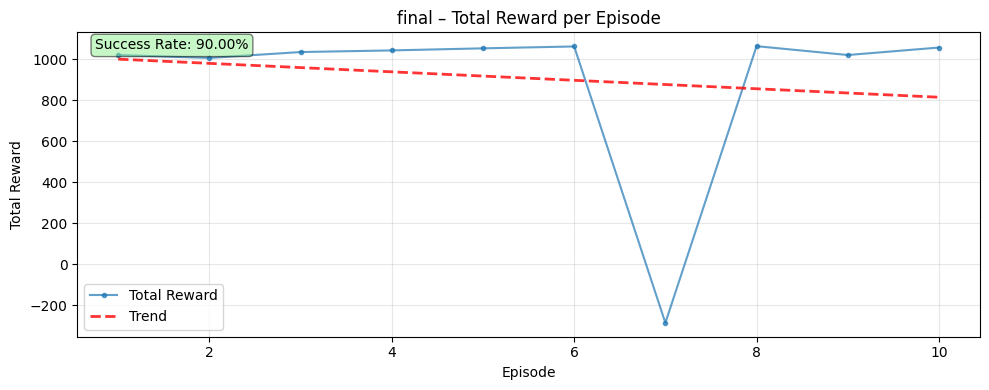

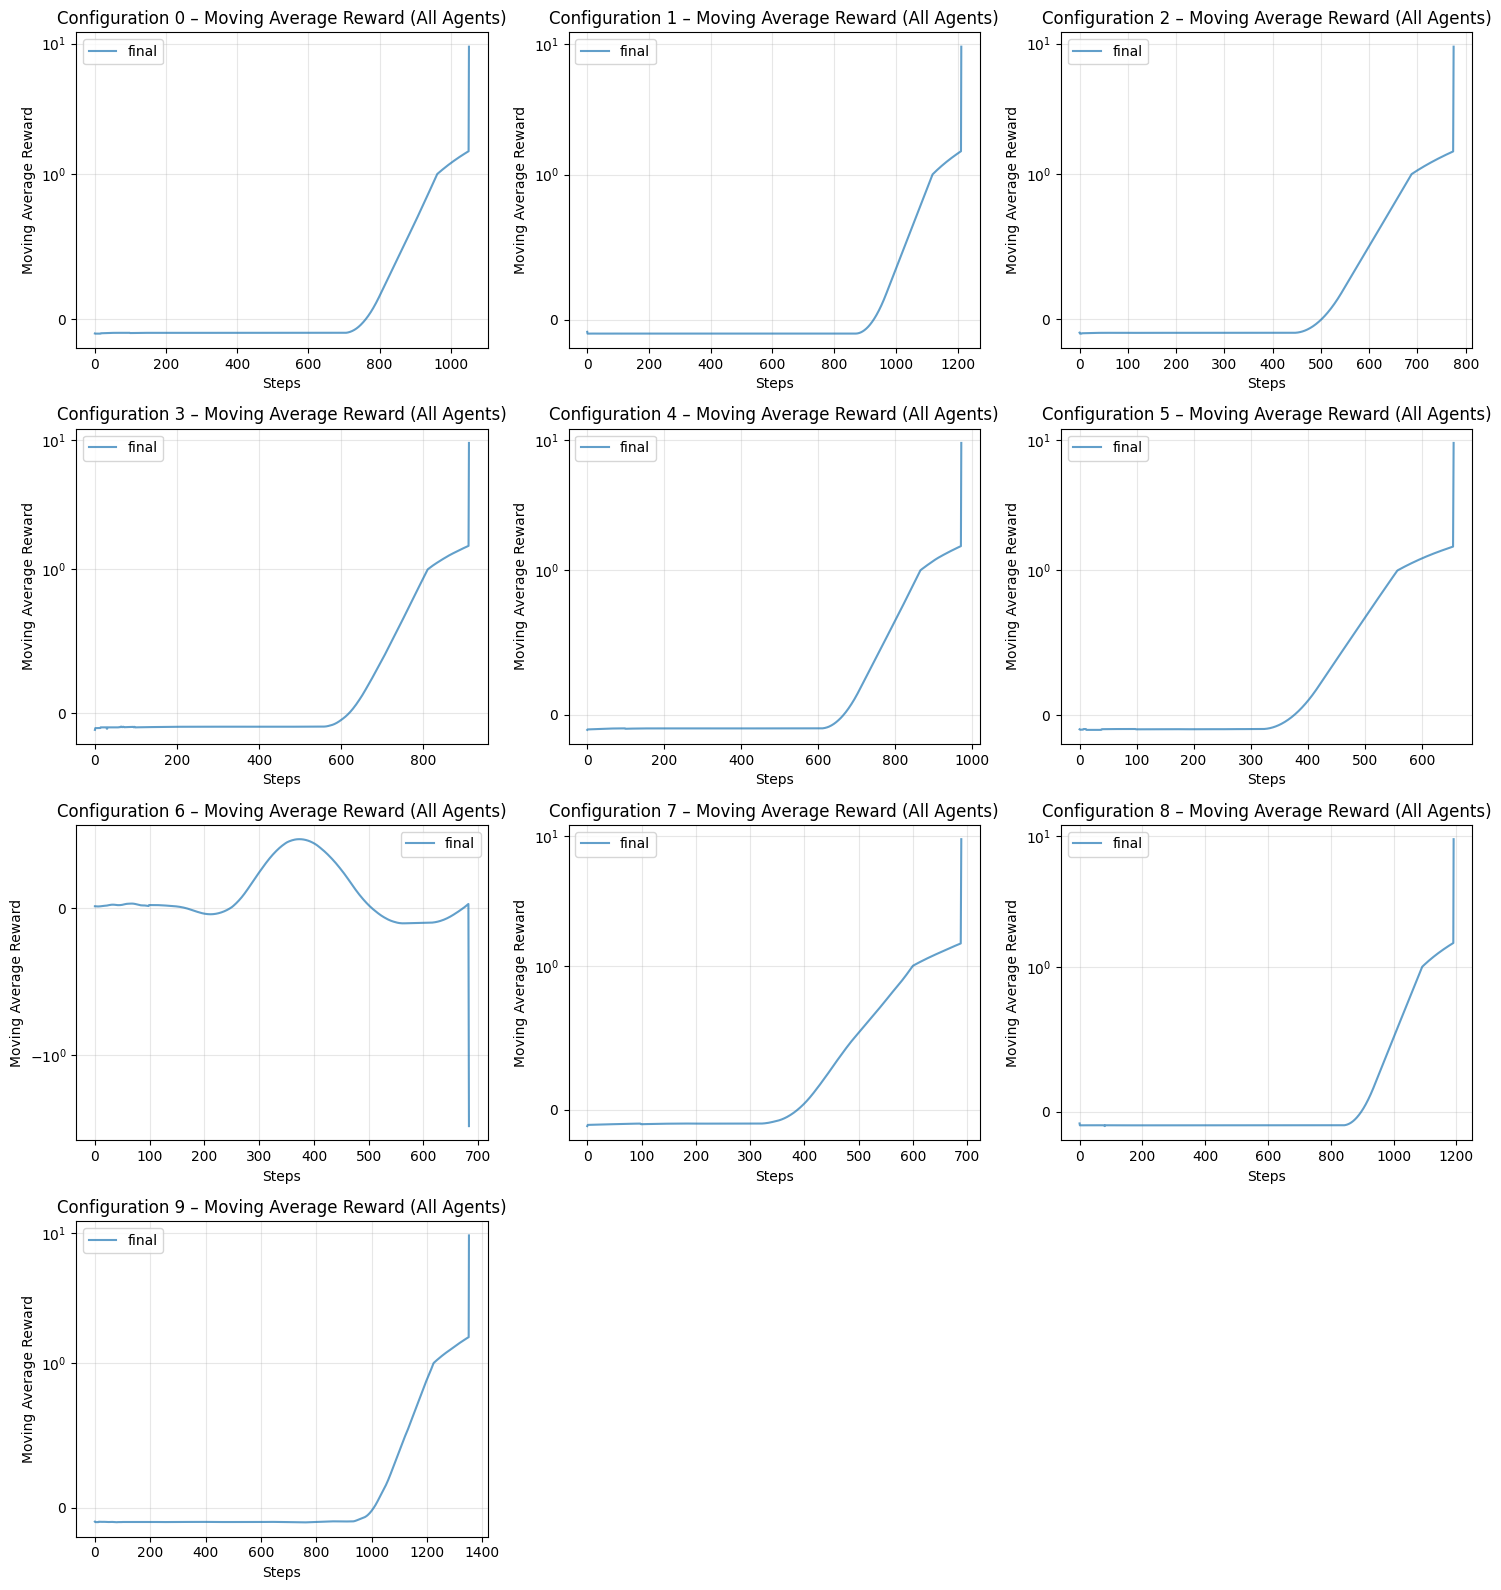

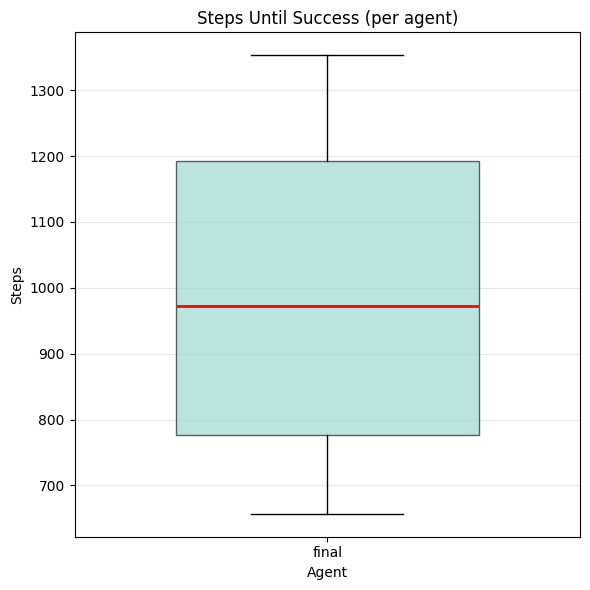

In [10]:
results = rename_inner_keys(results, {agent_id: "final"})
plot_all_q_agent(results, agents=["final"])

#### Confronto con checkpoint precedente

Per valutare l'evoluzione dell'apprendimento, confrontiamo il checkpoint finale con uno intermedio. Questo permette di osservare il miglioramento della policy e identificare eventuali regressioni.


#### Analisi del confronto

Il confronto tra i due checkpoint permette di tracciare una traiettoria precisa dell'apprendimento. In primo luogo, si valuta l'**evoluzione del Success Rate**, dove un incremento nell'agente finale conferma che il processo di ottimizzazione è proseguito fruttuosamente anche negli ultimi episodi. Parallelamente, si analizzano la **stabilità della Policy** e l'**efficienza** di navigazione: ci si attende che il modello finale mostri meno incertezze decisionali e, soprattutto, una riduzione del numero medio di step necessari per raggiungere l'obiettivo. Infine, il parametro della **State Coverage** funge da controllo di coerenza: entrambi i checkpoint dovrebbero mostrare una copertura dello spazio degli stati analoga, dato che la fase di esplorazione massiva avviene tipicamente nelle fasi iniziali del training.


2026-01-16 11:32:10,734 — INFO — Agent loaded from C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\src\notebooks\report\resources\checkpoints\phototaxis\q-learning\v1\light8-b1_ep100.npz
2026-01-16 11:32:10,735 — INFO —   Q-table shape: (24, 4)
2026-01-16 11:32:10,735 — INFO —   Current epsilon: 0.9555
2026-01-16 11:32:10,735 — INFO —   Total episodes trained: 100
Checkpoint precedente: ep100
Episodi: 15000


Evaluation: 100%|██████████| 10/10 [00:12<00:00,  1.21s/configuration run]
C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


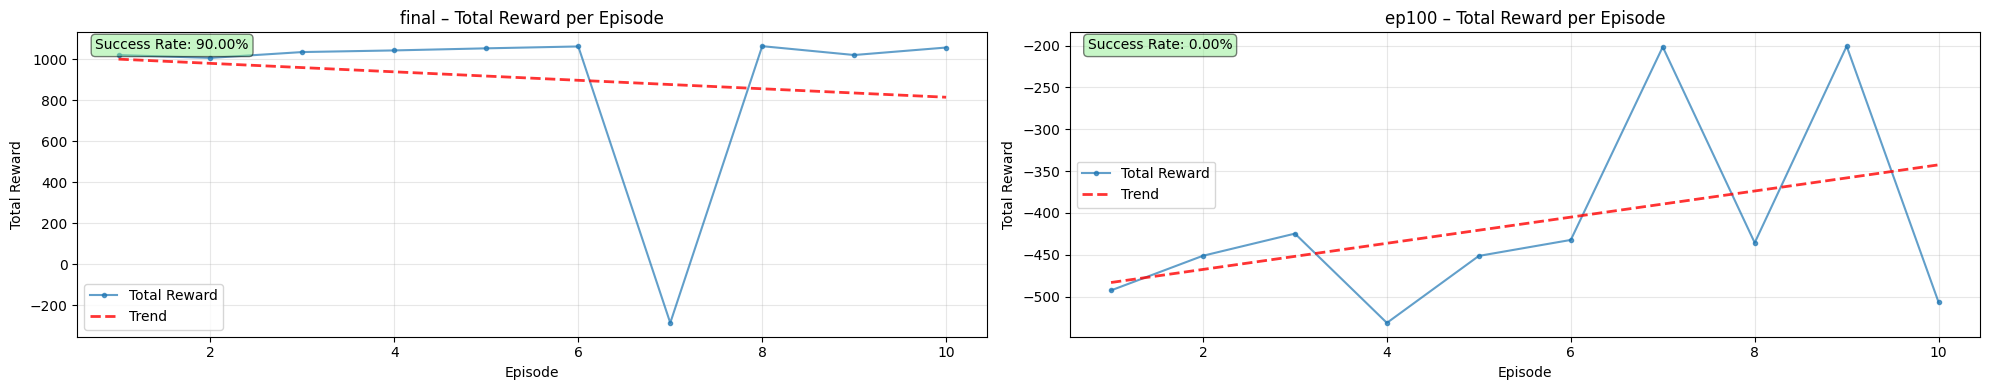

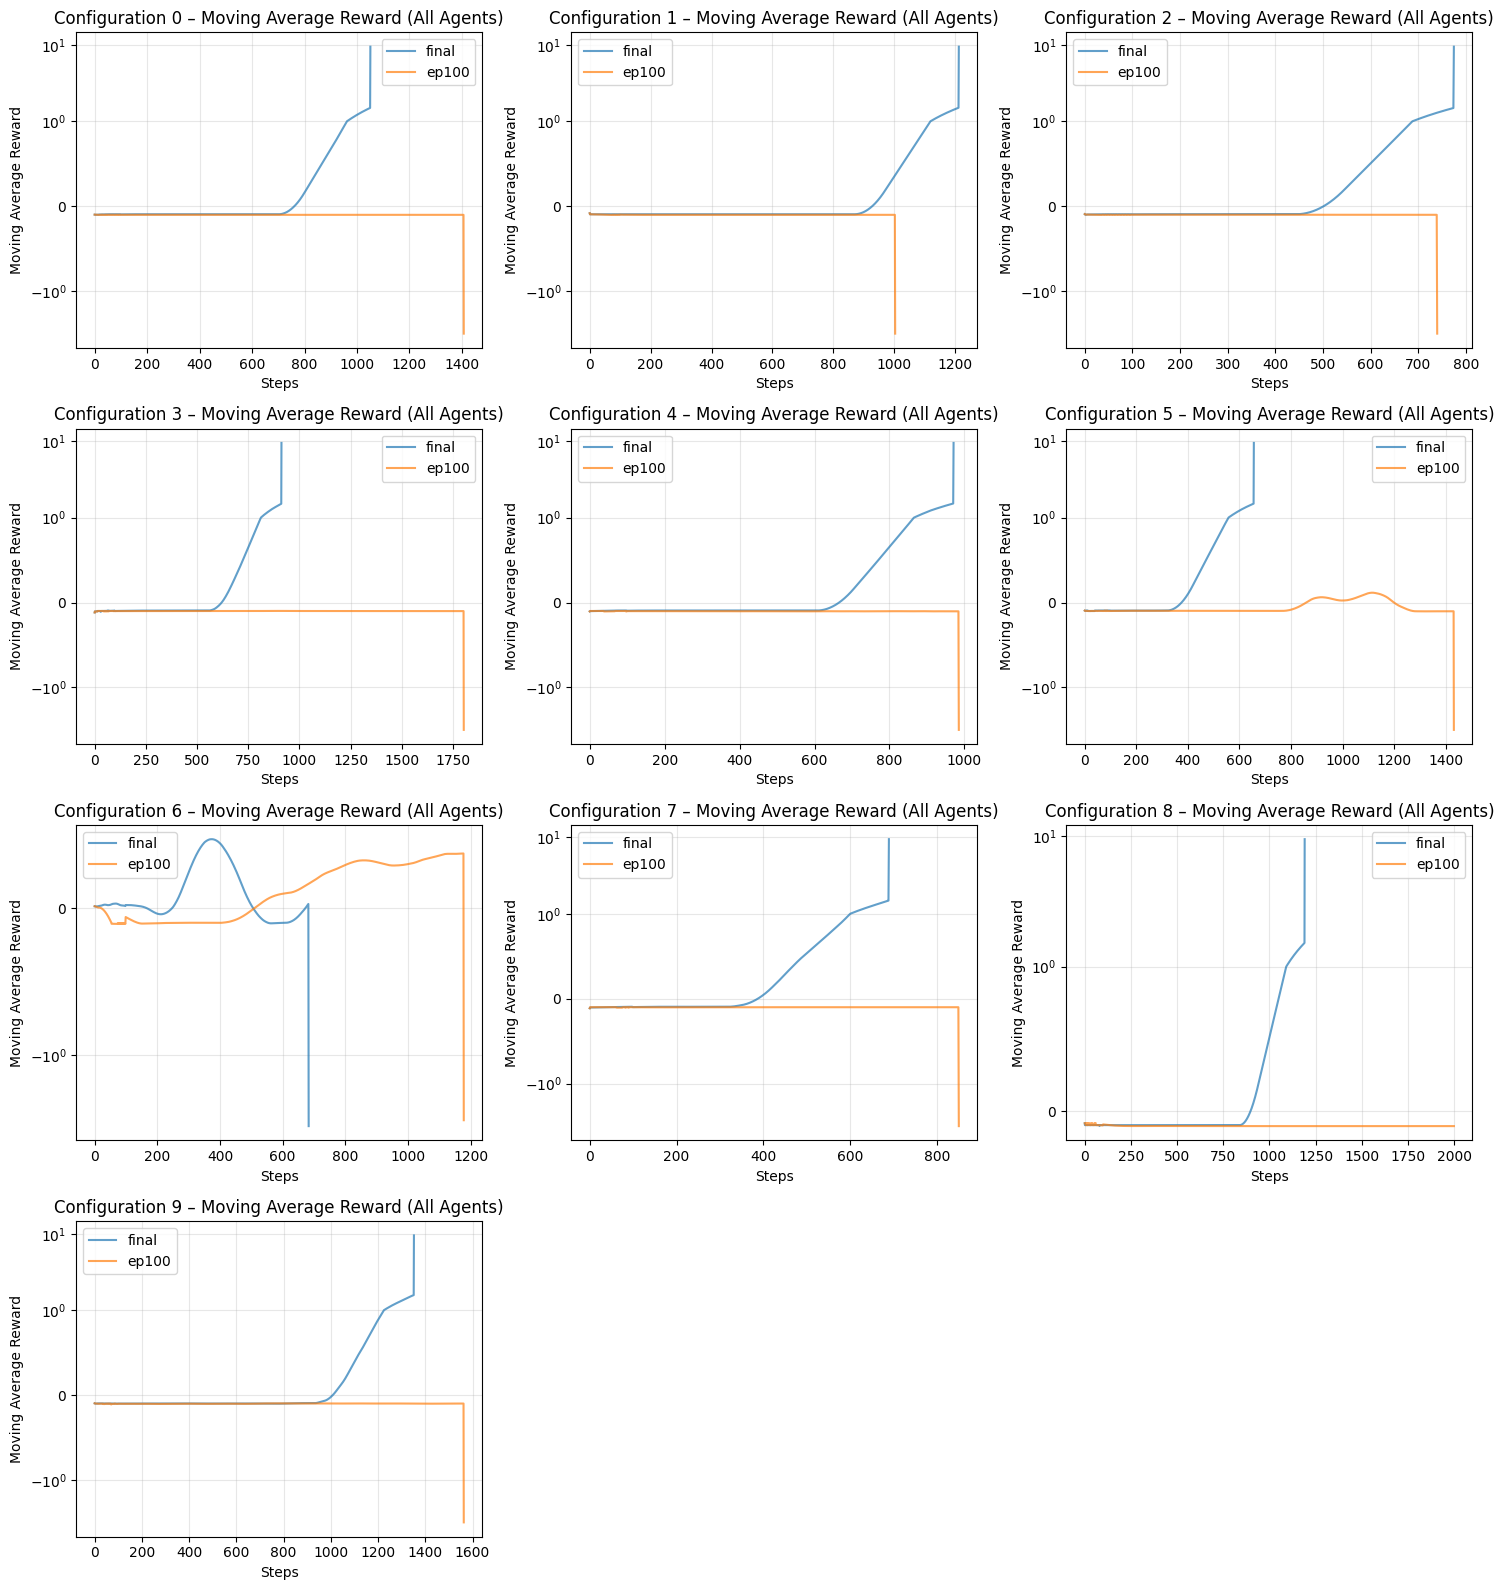

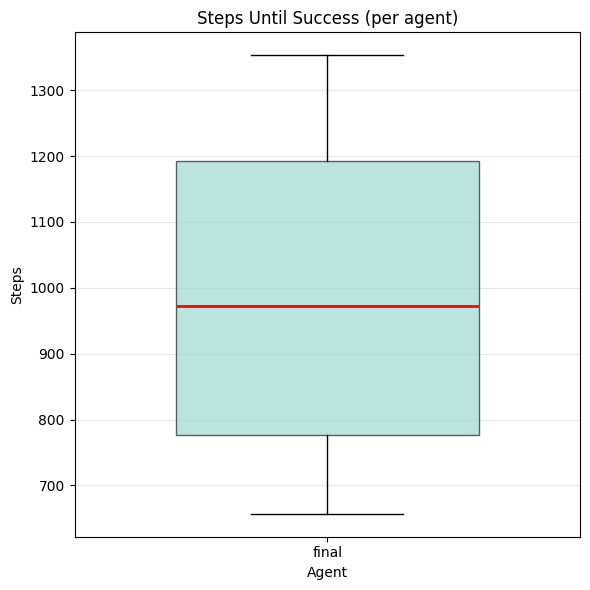

In [11]:
checkpoint_prev_path = get_yaml_path("src", "notebooks", "report", "resources",
                                "checkpoints", "phototaxis", "q-learning", "v1","light8-b1_ep100")

q_agent_prev = QAgent(q_env)
q_agent_prev.load(checkpoint_prev_path)
q_agents_prev = {agent_id: q_agent_prev}

print(f"Checkpoint precedente: ep100")
print(f"Episodi: {q_agent_prev.episodes if hasattr(q_agent_prev, 'episodes') else 'N/A'}")

prev_results = evaluate(env=q_env, agents=q_agents_prev, configs=configs, max_steps=2000, did_succeed=did_succeed)
prev_results = rename_inner_keys(prev_results, {agent_id: "ep100"})

combined_results = combine_inner_dict(results, prev_results)
plot_all_q_agent(combined_results, agents=["final", "ep100"])

### Analisi degli Errori e Performance

Con la configurazione finale `frontmin-b2/gentle4/light8-b2` e l'adozione della **reward V5**, l'agente ha dimostrato prestazioni solide, raggiungendo un **success rate del 90%** sui migliori checkpoint e garantendo il **100% state coverage** (tutti gli stati visitati). I valori di **Q-max (~907)** indicano che l'agente riesce a massimizzare efficacemente la ricompensa cumulativa a lungo termine.

#### Comportamento e Dinamiche di Apprendimento

Il comportamento osservato evidenzia una navigazione decisa verso la sorgente luminosa, indipendentemente dalla posizione iniziale. Questo risultato è reso possibile dalla sinergia tra un **progress** (ProgressScale = 8.0), che fornisce il gradiente necessario per l'avvicinamento, e un **tractor beam** (TractorBeamScale = 15.0), che elimina le esitazioni finali garantendo stabilità una volta raggiunto il target.

L'attuale stabilità è il frutto di un processo iterativo volto a correggere tre criticità principali emerse durante lo sviluppo:

1. inizialmente, una ricompensa di progresso insufficiente portava l'agente a ruotare su se stesso per accumulare piccole reward senza avanzare;
2. prima del potenziamento del *tractor beam*, l'agente tendeva a fermarsi o oscillare appena percepita la luce, senza completare il task;
3. l'introduzione di un bonus per la rilevazione della luce aveva introdotto troppo rumore stocastico, causando cambi di direzione improvvisi.
4. 
Nonostante il successo, l'agente rimane vincolato dai limiti intrinseci della discretizzazione. La **perdita di precisione** (solo 2 bins per la luce) impedisce di distinguere tra intensità deboli e medie, mentre la configurazione sensoriale semplificata (`frontmin`) nasconde la posizione laterale degli ostacoli (**direzioni prossimità limitate**). Infine, la natura contenuta dell'ambiente (5x5) semplifica il task, poiché l'agente percepisce sempre la luce, non dovendo mai gestire fasi di pura esplorazione al buio.


#### Analisi dei Comportamenti Appresi

L'analisi quantitativa è stata affiancata da un'ispezione visiva della policy appresa, focalizzandosi su due aspetti critici: la capacità di raggiungere il target e la gestione degli ostacoli imprevisti.

##### Navigazione e Successo

Nel primo scenario, osserviamo l'agente configurato con la **Reward V5** (Strong Progress + Tractor Beam).
Nonostante la bassa risoluzione sensoriale (solo 8 direzioni cardinali per la luce), l'agente mostra un comportamento deciso:

1. **Orientamento:** individua immediatamente il gradiente di luce più forte;
2. **Avvicinamento:** procede verso la sorgente minimizzando le deviazioni;
3. **Targeting:** il "tractor beam" garantisce che l'agente entri effettivamente nell'area del goal senza oscillare sui bordi.

![Final Agent Behavior](../resources/pho-qagent-success.gif)

Nelle prime versioni della reward, l'agente mostrava un comportamento degenere: ruotava continuamente sul posto senza mai avanzare verso la luce.

Il segnale di progress (ProgressScale=2.0) era troppo debole rispetto alla StepPenalty. L'agente non riceveva abbastanza rinforzo positivo per imparare che avanzare verso la luce era vantaggioso.

##### Evitamento dei Bordi

Il secondo scenario evidenzia un risultato interessante.
Come descritto nella sezione "Osservazioni", i sensori di prossimità sono stati ridotti a un singolo bit di informazione ("ostacolo vicino/lontano") per ridurre lo spazio degli stati. **Non è stata programmata alcuna regola euristica di evitamento** (nessun *if obstacle then turn*).

Ciononostante, l'agente ha appreso autonomamente che lo stato `(Prossimità=ALTA)` è statisticamente correlato a una futura penalità di collisione. Di conseguenza, la Q-Table ha sviluppato una preferenza per l'azione di **rotazione** quando i sensori frontali si attivano, deviando la traiettoria quel tanto che basta per evitare l'impatto.

![Final Agent Behavior](../resources/pho-qagent-avoid-boundary.gif)

### Commenti Finali

L'approccio con Q-Learning tabellare ha permesso di affrontare il task di phototaxis in modo diretto, distinguendosi per importanti punti di forza. Il sistema offre un'**interpretabilità completa**, permettendo di ispezionare le preferenze dell'agente per ogni stato, e assicura una **convergenza garantita** e stabile grazie allo spazio ridotto. 

Tuttavia, per mantenere la trattabilità si è reso necessario un **compromesso percettivo**, sacrificando l'informazione sensoriale per adattarla alla discretizzazione. Questo comporta una **generalizzazione limitata**, in quanto l'agente non può interpolare tra gli stati, e una forte **dipendenza dalla discretizzazione** stessa, dove la scelta delle soglie impatta drasticamente le performance. 

Tali limitazioni motivano il passaggio al **Deep Q-Learning**, che permette di elaborare direttamente i valori continui offrendo una superiore capacità di approssimazione.

#### Nota sulla Valutazione: Assenza di Test su Ambienti Più Grandi

A differenza del Deep Q-Learning, il Q-Learning non è stato valutato su ambienti 20×20 e 30×30. Questa scelta è motivata dalla natura stessa dell'encoding utilizzato:

- l'agente percepisce solo la **direzione della luce** (8 direzioni cardinali discretizzate), non la distanza assoluta dalla sorgente né le dimensioni dell'ambiente. Dal suo punto di vista, un ambiente 5×5 e uno 30×30 sono indistinguibili: ciò che conta è unicamente la direzione del gradiente luminoso.

- la configurazione finale (`frontmin-b2`) utilizza i sensori di prossimità in modo molto limitato (un singolo bit "ostacolo vicino/lontano"). L'agente non ha appreso una vera capacità di navigazione spaziale o di evitamento ostacoli sofisticato.

- poiché l'agente risponde solo alla direzione della luce, i risultati su ambienti più grandi sarebbero sostanzialmente gli stessi del 5×5, a patto che la luce sia sempre percepibile. La differenza sarebbe solo nel numero di step necessari per raggiungere il goal, non nel success rate.

Questo evidenzia una limitazione fondamentale del Q-Learning tabellare: la necessità di discretizzare l'input impedisce di catturare informazioni spaziali utili per la generalizzazione a scale diverse.

# Deep Q-Learning

Nel DQN, la tabella viene sostituita da una **Rete Neurale**. Non dobbiamo più discretizzare l'input. L'agente può vedere il mondo in "alta definizione", utilizzando tutti i 16 sensori con valori continui.



## Import delle librerie

In [2]:
import sys
sys.path.append("../..")

from environment.deepqlearning.phototaxis_env import PhototaxisEnv as DQPhotoEnv
from agent.scala_dqagent import DQAgent
from training.dqnetwork import DQNetwork

## Connessione all'ambiente

In [3]:
server_address = "localhost:50051"
client_name = "PhototaxisDQClient"
dq_env = DQPhotoEnv(server_address, client_name)
dq_env.connect_to_client()

2026-01-16 12:19:41,959 — INFO — ✓ Connected to localhost:50051



d## Configurazioni ambienti

Per il training del DQN è stato costruito un **dataset di 300 configurazioni selezionate manualmente**. La scelta di non affidarsi alla generazione casuale nasce dall'osservazione che molti ambienti randomici risultavano "complessi"  o banali (luce a pochi centimetri), introducendo rumore nel training senza contribuire all'apprendimento.


### Caratteristiche dell'ambiente

| Proprietà | Valore |
|-----------|--------|
| Dimensione arena | 10×10 unità (fissa) |
| Numero luci | 1-3 per ambiente (media: 1.76) |
| Raggio illuminazione | 4.0-8.0 unità (media: 5.85) |
| Distanza iniziale agente-luce | 1.02-11.20 unità (media: 5.85) |

### Distribuzione degli Spawn

Un aspetto critico degli ambienti è la distribuzione delle posizioni iniziali dell'agente:

- **57% "In Light"**: l'agente viene generato in una zona già illuminata (distanza 1.4-5.7 unità). Questi ambienti servono per imparare il *tracking* del gradiente luminoso.
- **43% "Out of Light"**: l'agente nasce totalmente al buio (distanza > 6.8 unità). Questi ambienti servono per imparare a **esplorare** quando non si percepisce alcun segnale.

Un dataset con solo spawn "in luce" produceva agenti incapaci di reagire al buio, mentre troppi spawn "al buio" rallentavano l'apprendimento della navigazione verso il gradiente.
Variando continuamente la posizione di start, delle luci e degli ostacoli, costringiamo la rete a ignorare la sua posizione assoluta (che cambia sempre) e a focalizzarsi esclusivamente sulle correlazioni tra sensori e azioni ottime.

### Complessità degli Ambienti

Gli ambienti sono stati categorizzati in tre livelli di difficoltà:

- **Facili (~30%)**: 1 luce singola, raggio > 6.0, distanza iniziale < 6.0
- **Medi (~50%)**: 1-2 luci, raggio 5.0-7.0, distanza variabile
- **Difficili (~20%)**: 2-3 luci (scelta strategica necessaria), raggio < 5.0 (luce debole), distanza > 8.0

## Osservazioni

A differenza della drastica riduzione operata nel Q-Learning (solo cardinali e discretizzati), il DQN riceve in input il vettore grezzo dei **16 sensori** (8 luce + 8 prossimità).
Questa scelta permette alla rete neurale di agire come estrattore di feature, conservando sfumature cruciali:

* la capacità di percepire variazioni decimali di intensità luminosa permette correzioni di rotta più fluide rispetto ai soli 3 livelli del tabellare;
* l'agente può dedurre la posizione della luce anche quando questa si trova tra due sensori (es. 45°), superando la rigidità dei sensori cardinali.

### Spazio delle Azioni

Per sfruttare la precisione dei sensori continui, lo spazio delle azioni è stato esteso rispetto alle sole rotazioni cardinali. Il set di azioni comprende:

* **Forward**: avanzamento diretto;
* **Hard Turn (Left/Right)**: rotazione rapida per cambi di direzione decisi o evitamento ostacoli;
* **Soft Turn (Left/Right)**: rotazioni con raggio ampio.

L'introduzione dei *Soft Turn* si è rivelata fondamentale per la stabilità. Mentre il Q-Learning tabellare procedeva a "scatti", il DQN necessita di correzioni fini per mantenere l'agente allineato al gradiente di luce senza entrare in oscillazione continua attorno al vettore obiettivo.

## Architettura e Iperparametri

La complessità del task, in particolare la necessità di generalizzare su 300 ambienti diversi, ha richiesto una rete con capacità adeguata a evitare l'underfitting. La struttura finale (`[256, 128, 64]`) con circa 45.000 parametri rappresenta il miglior compromesso individuato: reti più piccole rischiavano di non catturare la variabilità degli ambienti, mentre reti più profonde tendevano a manifestare instabilità nella convergenza dei Q-values.

### Iperparametri Chiave

| Parametro | Valore | Motivazione |
|-----------|--------|-------------|
| γ (discount) | 0.99 | Focus sul goal a lungo termine |
| ε-max | 1.0 | Esplorazione totale iniziale |
| ε-min | 0.01 | Esplorazione residua |
| Replay Memory | 100.000 | Buffer esperienze sufficientemente ampio |
| Steps per Update | 4 | Aggiornamento frequente della rete |
| Target Update | 1.000 | Stabilità della target network |

## Evoluzione del Training e Reward Engineering

A differenza dell'approccio tabellare, dove i problemi erano spesso visibili nella Q-Table, nel Deep Q-Learning le criticità si manifestavano come instabilità numerica o mancata convergenza. L'ottimizzazione ha richiesto un'analisi profonda non solo della *forma* della reward, ma anche della sua *scala* e delle dinamiche di addestramento.

### 1. Il problema della Scala dei Reward

Inizialmente, la soglia per considerare un episodio "risolto" era impostata a 5.000. Tuttavia, un'analisi dei valori grezzi ha rivelato un'incongruenza fondamentale:

* un successo rapido (20 step) generava circa **46 punti**;
* un successo lento (100 step) generava circa **126 punti** (accumulando reward positive di avvicinamento);
* una collisione costava circa **-27 punti**.

La soglia di 5.000 era matematicamente irraggiungibile, rendendo impossibile per l'agente capire quando aveva fatto "abbastanza bene".

**Soluzione:** la soglia di stop è stata ricalibrata a **40.0** (media mobile), un valore realistico che indica una navigazione consistente verso la luce.

### 2. Epsilon Decay e Overfitting

Con il decay esponenziale standard, il tasso di esplorazione ($\epsilon$) scendeva sotto lo 0.10 già all'episodio 2.500. Dato che il dataset conteneva 300 ambienti diversi, l'agente smetteva di esplorare troppo presto, andando in *overfitting* sulle prime configurazioni viste e fallendo nel generalizzare su quelle successive.

**Soluzione:** il decay è stato rallentato per garantire un'esplorazione significativa ($\epsilon > 0.01$) fino all'episodio 7.500, permettendo all'agente di vedere e "digerire" l'intera varietà degli ambienti.

### 3. Compressione dell' Orizzonte Temporale

Il limite originale di **900 step** si è rivelato controproducente. Un'analisi fisica dell'ambiente (10x10 unità, velocità 1.0) mostra che il tempo ottimale di percorrenza è tra i **6 e i 30 step**.
Un orizzonte di 900 step (30 volte il necessario) permetteva all'agente di vagare casualmente senza subire penalità significative, diluendo il gradiente di apprendimento.

**Soluzione:** Il limite è stato ridotto drasticamente a **200 step**. Questo vincolo funge da *implicit reward shaping*: ogni deviazione inutile avvicina pericolosamente il timeout, rendendo l'efficienza una priorità assoluta per la sopravvivenza dell'agente.




## Funzione di Reward Finale

La funzione di reward ha assunto la seguente forma:

### Parametri Implementati

```scala
private val ProgressScale = 5.0           // Bilancia segnale vs rumore (SNR ~6.7)
private val StepPenalty = -0.004          // Incentivo efficienza
private val DarknessPenalty = -0.006      // Penalità per navigazione al buio
private val StationaryPenalty = -0.025    // Anti-stuck mechanism
private val StationaryThreshold = 0.01    // Soglia movimento minimo
private val GoalBonus = 1.5               // Reward terminale dominante
private val FailurePenalty = -2.0         // Penalità per collisione
private val NoLightThreshold = 0.01       // Soglia percezione luce
```

### Logica della Reward

```scala
if goalReached then
  GoalBonus + StepPenalty                 // +1.496 (termina episodio)
  
else if collided then
  FailurePenalty                          // -2.0 (termina episodio)
  
else
  val maxLight = sensori_luce.max()
  
  if maxLight < NoLightThreshold then
    // Al buio: NO progress reward (evita "magic compass")
    DarknessPenalty + StepPenalty + stationaryCheck
  else
    // In luce: reward basata sul progresso verso la luce
    val progress = (prevDistance - currDistance) * ProgressScale
    progress + StepPenalty + stationaryCheck
```

Le idee finali chiave sono state:
1. il rapporto tra `GoalBonus` e il potenziale farming è sufficientemente alto da rendere il completamento sempre la strategia migliore;
2. il progress viene calcolato solo quando l'agente percepisce effettivamente luce. Al buio, riceve solo penalità che lo spingono a esplorare;
3. la `StationaryPenalty` previene comportamenti degeneri come rimanere fermi o oscillare sul posto.

## Deep Q-Agent

### Inizializzazione e Caricamento

Di seguito viene mostrato il codice per inizializzare l'agente DQN con l'architettura descritta e caricare i pesi del modello addestrato.

In [4]:
dq_init_env_path = get_yaml_path("src", "notebooks", "report", "resources", "environments", "phototaxis", "q-learning", "5x5","environment_0000.yml")
dq_init_env = read_file(dq_init_env_path)
dq_env.init(dq_init_env)

neuron_count_per_hidden_layer = [256, 128, 64]
dq_agent_id = "00000000-0000-0000-0000-000000000001"
dq_agent = DQAgent(
    dq_env,
    agent_id=dq_agent_id,
    action_model=DQNetwork(
        dq_env.observation_space.shape,
        neuron_count_per_hidden_layer,
        dq_env.action_space.n,
        summary=False,
    ),
    target_model=DQNetwork(
        dq_env.observation_space.shape,
        neuron_count_per_hidden_layer,
        dq_env.action_space.n,
        summary=False,
    ),
)
dq_agents = {dq_agent_id: dq_agent}

### Caricamento agente salvato

In [5]:
path = get_yaml_path("src", "notebooks", "report", "resources", "checkpoints", "phototaxis", "dq-learning", "v1")
dq_agent.load(path)
print("DQ-Agent hyperparameters:")
print(f"\tEpsilon-max: {dq_agent.epsilon_max}")
print(f"\tEpsilon-min: {dq_agent.epsilon_min}")
print(f"\tGamma: {dq_agent.gamma}")
print(f"\tReplay memory max size: {dq_agent.replay_memory.maxlen}")
print(f"\tSteps per update: {dq_agent.step_per_update}")
print(f"\tSteps per update target: {dq_agent.step_per_update_target_model}")

DQ-Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.01
	Gamma: 0.99
	Replay memory max size: 100000
	Steps per update: 4
	Steps per update target: 1000


C:\Users\David\Github\university\first_year\second_semester\PPS-22-srs\python\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Caricamento ambienti di valutazione

In [10]:
# 5x5 configurations
dq_config_5_path = get_yaml_path("src", "notebooks", "report", "resources", "environments", "phototaxis", "dq-learning", "5x5")
dq_yml_files_5 = sorted(dq_config_5_path.glob("*.yml"), key=lambda p: p.name)
dq_configs_5 = [read_file(yml) for yml in dq_yml_files_5]

# 20x20 configurations
dq_config_20_path = get_yaml_path("src", "notebooks", "report", "resources", "environments", "phototaxis", "dq-learning", "20x20")
dq_yml_files_20 = sorted(dq_config_20_path.glob("*.yml"), key=lambda p: p.name)
dq_configs_20 = [read_file(yml) for yml in dq_yml_files_20]

# 30x30 configurations
dq_config_30_path = get_yaml_path("src", "notebooks", "report", "resources", "environments", "phototaxis", "dq-learning", "30x30")
dq_yml_files_30 = sorted(dq_config_30_path.glob("*.yml"), key=lambda p: p.name)
dq_configs_30 = [read_file(yml) for yml in dq_yml_files_30]

print(f"Caricati ambienti di valutazione")

Caricati ambienti di valutazione


#### Creazione della funzione di valutazione

La funzione di valutazione determina il successo dell'episodio basandosi sulla reward ricevuta dal server Scala.


In [11]:
did_succeed = lambda reward, termination, truncation, infos: True if termination and reward > 0.5 else False

#### Valutazione dell'agente

In [12]:
dq_final_results_5 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_5, max_steps=5000, did_succeed=did_succeed)
dq_final_results_20 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_20, max_steps=20000, did_succeed=did_succeed)
dq_final_results_30 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|██████████| 20/20 [07:03<00:00, 21.18s/configuration run]


In [13]:
dq_final_results_5 = rename_inner_keys(dq_final_results_5, {dq_agent_id: "final"})
dq_final_results_20 = rename_inner_keys(dq_final_results_20, {dq_agent_id: "final"})
dq_final_results_30 = rename_inner_keys(dq_final_results_30, {dq_agent_id: "final"})

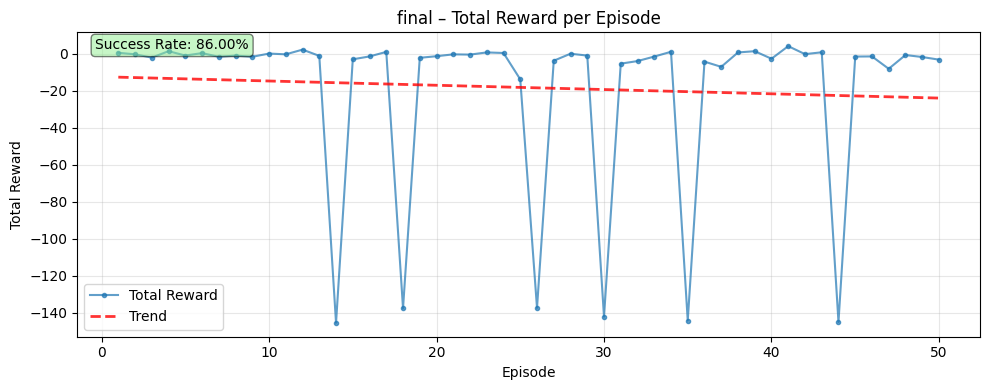

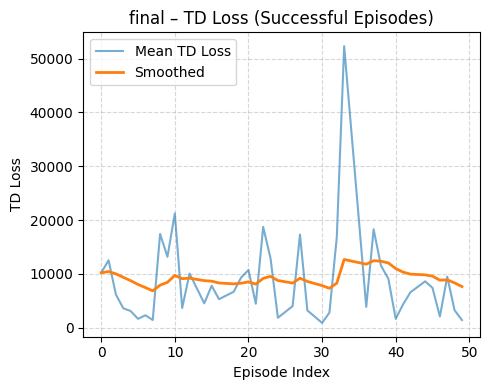

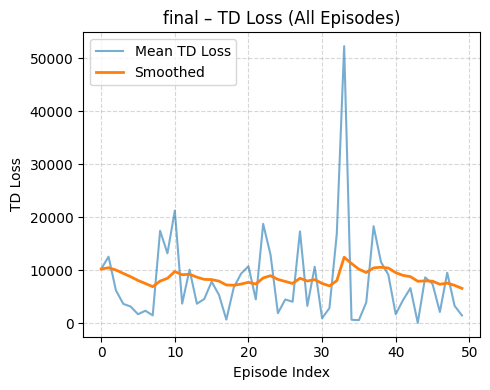

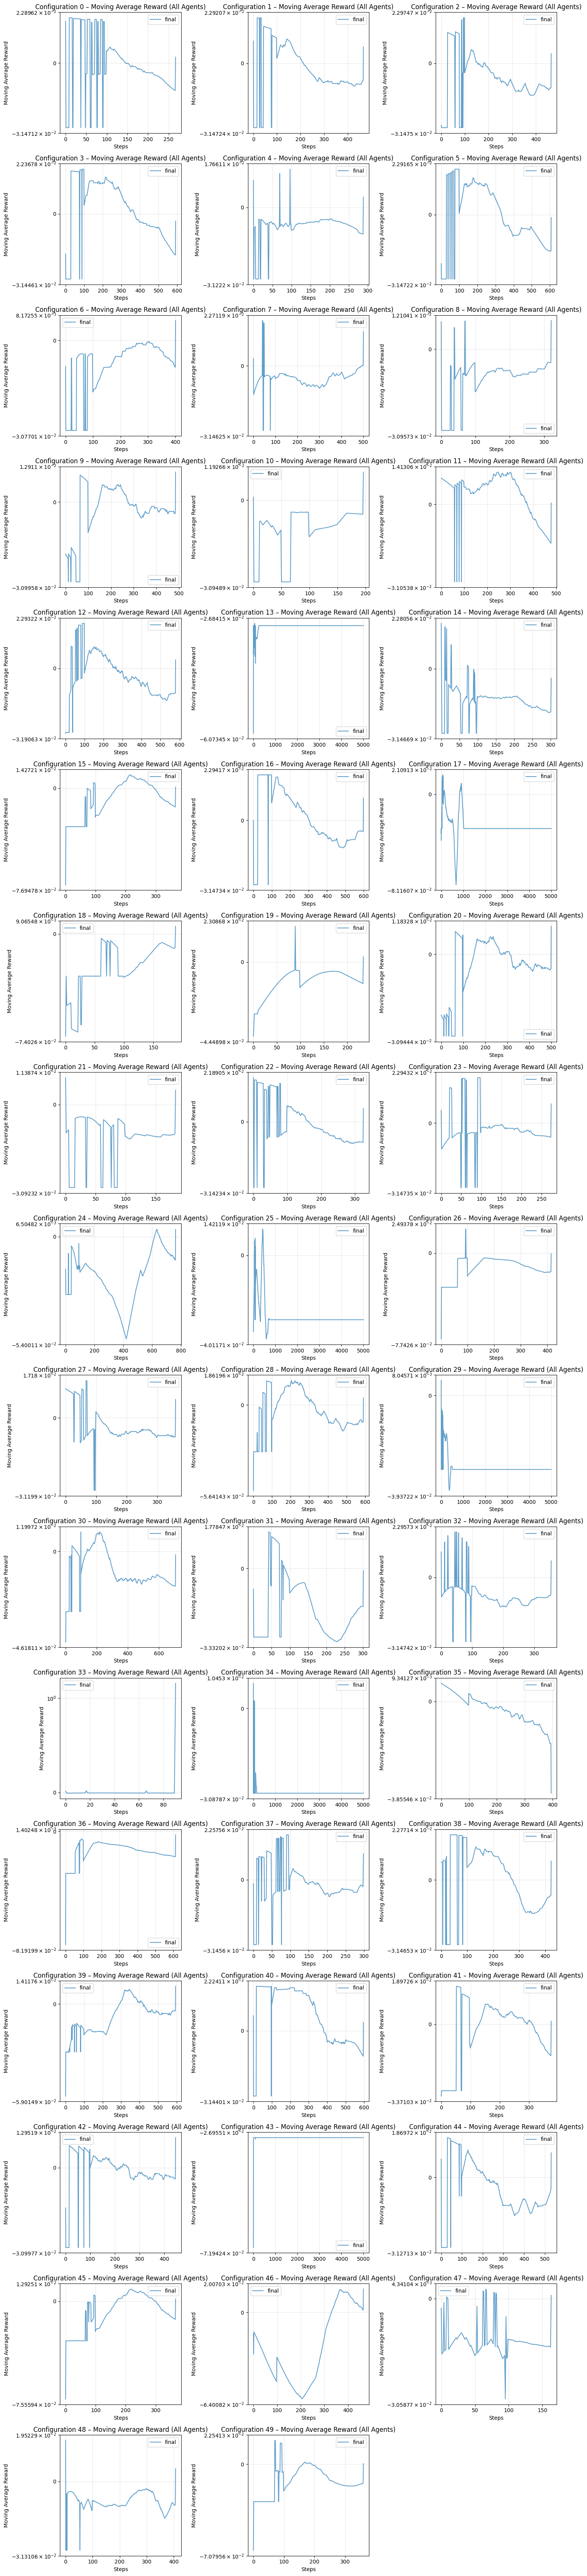

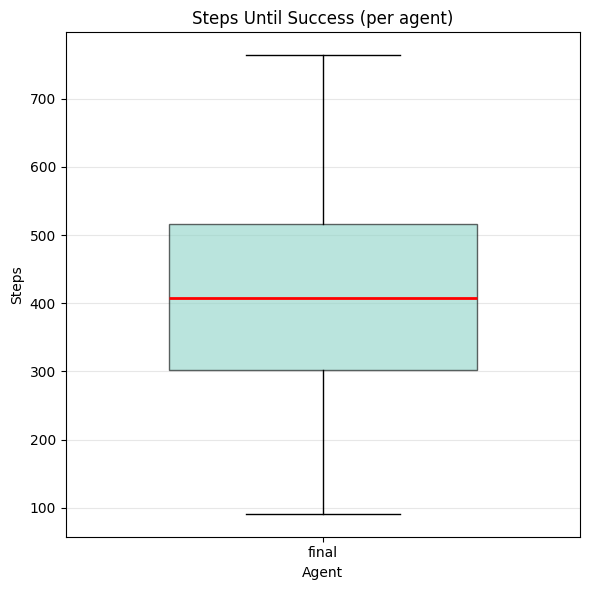

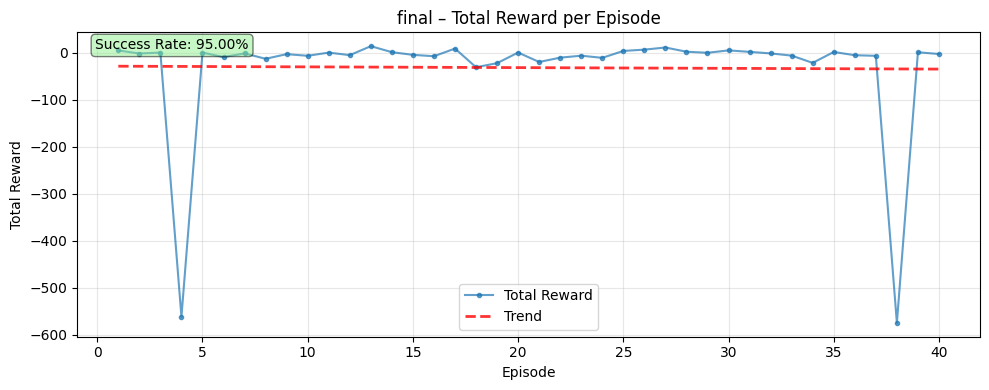

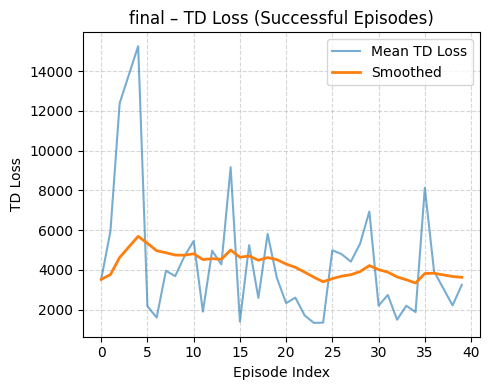

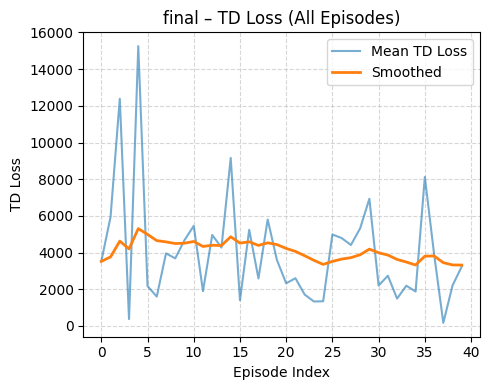

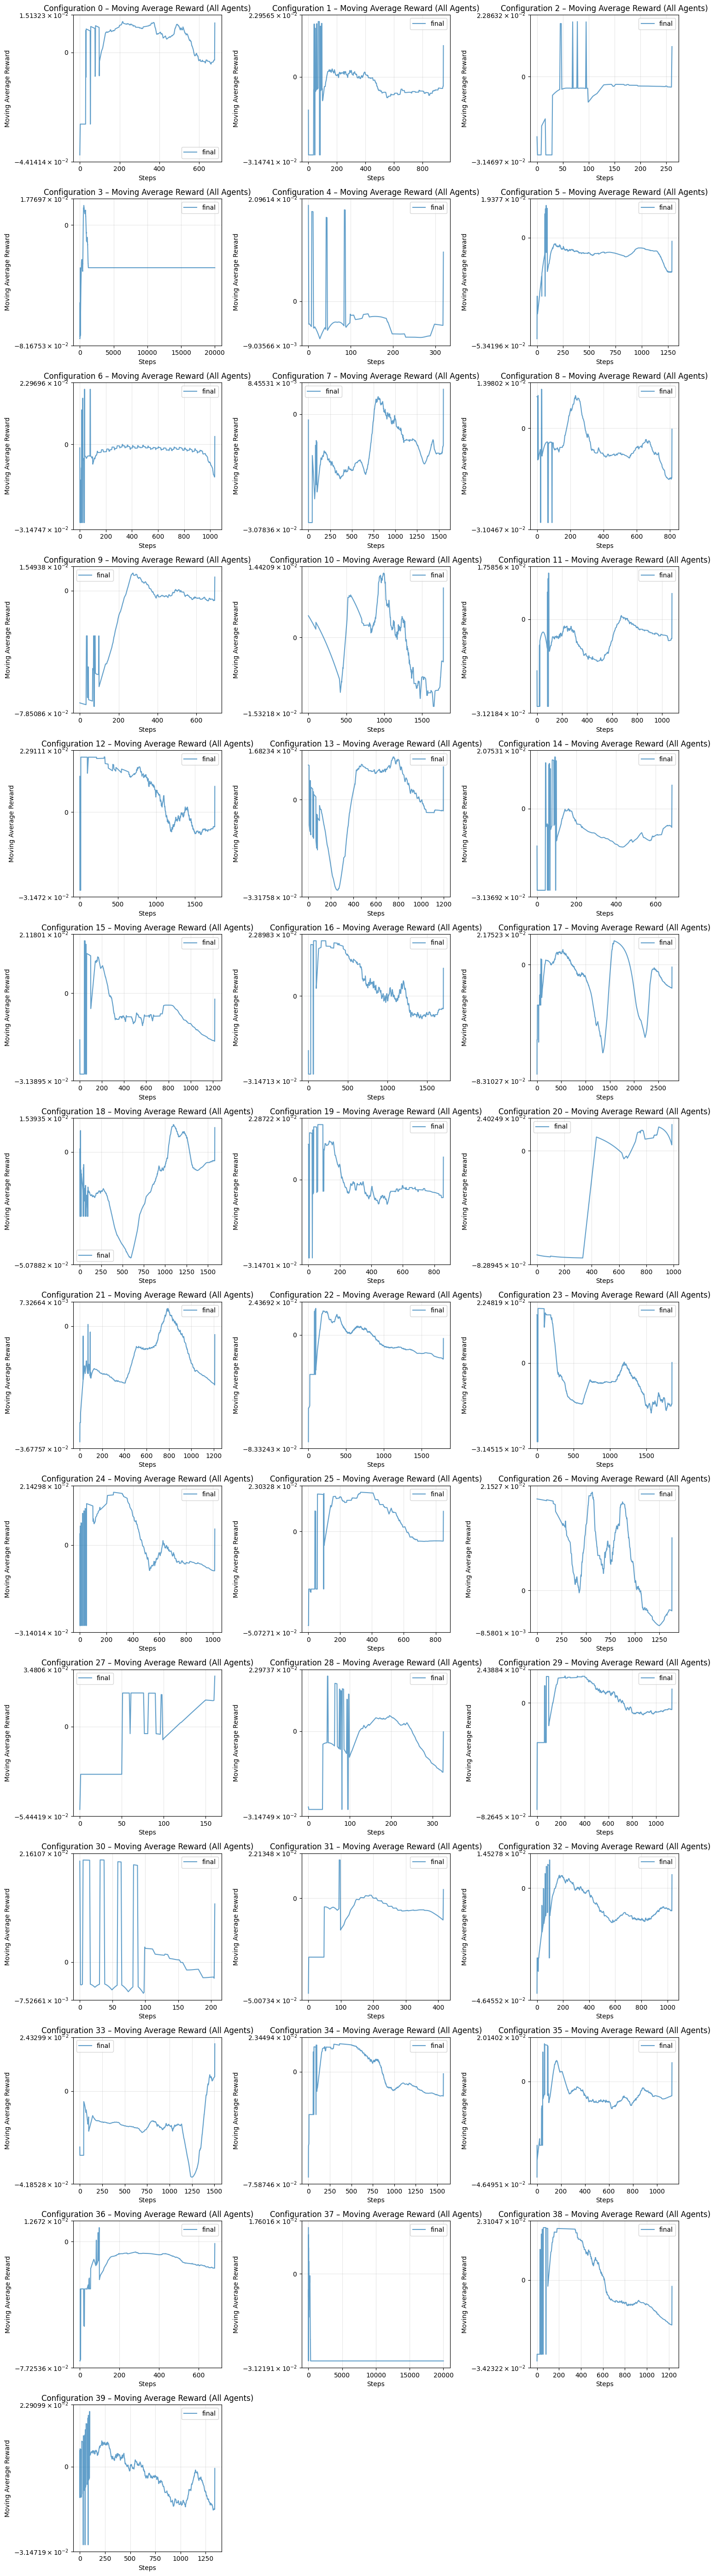

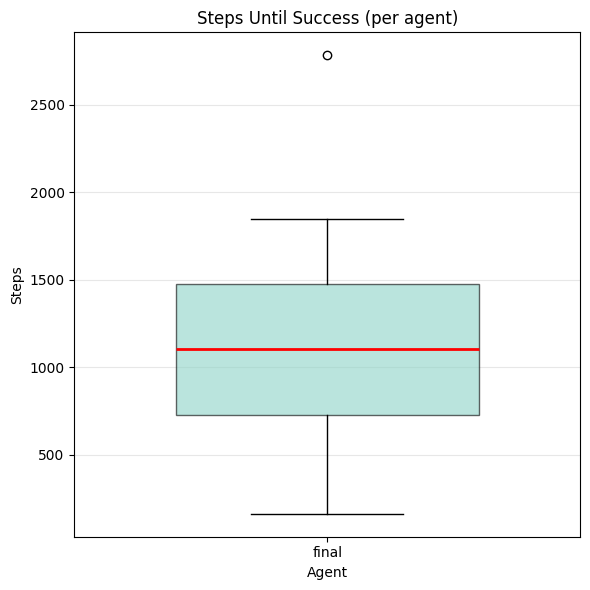

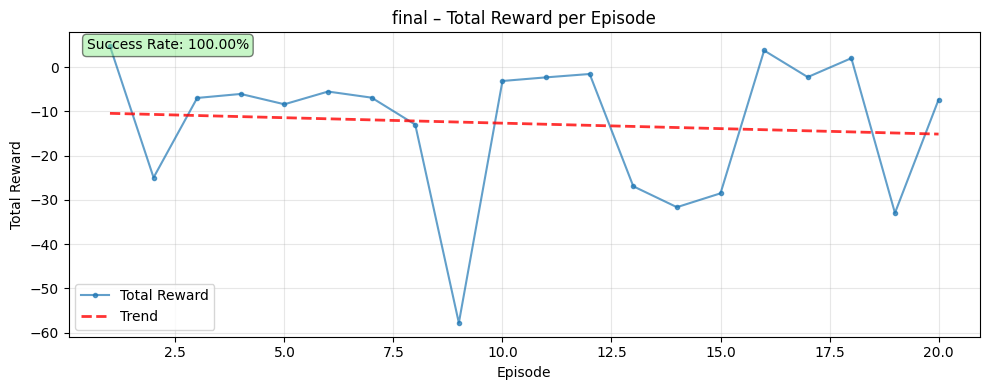

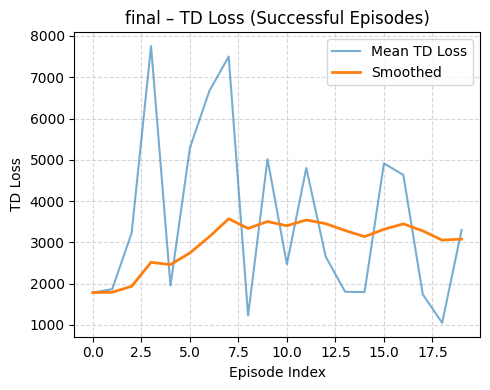

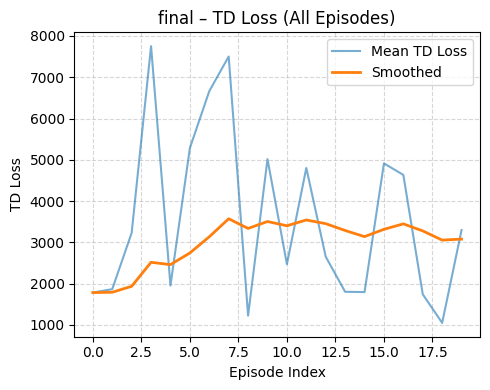

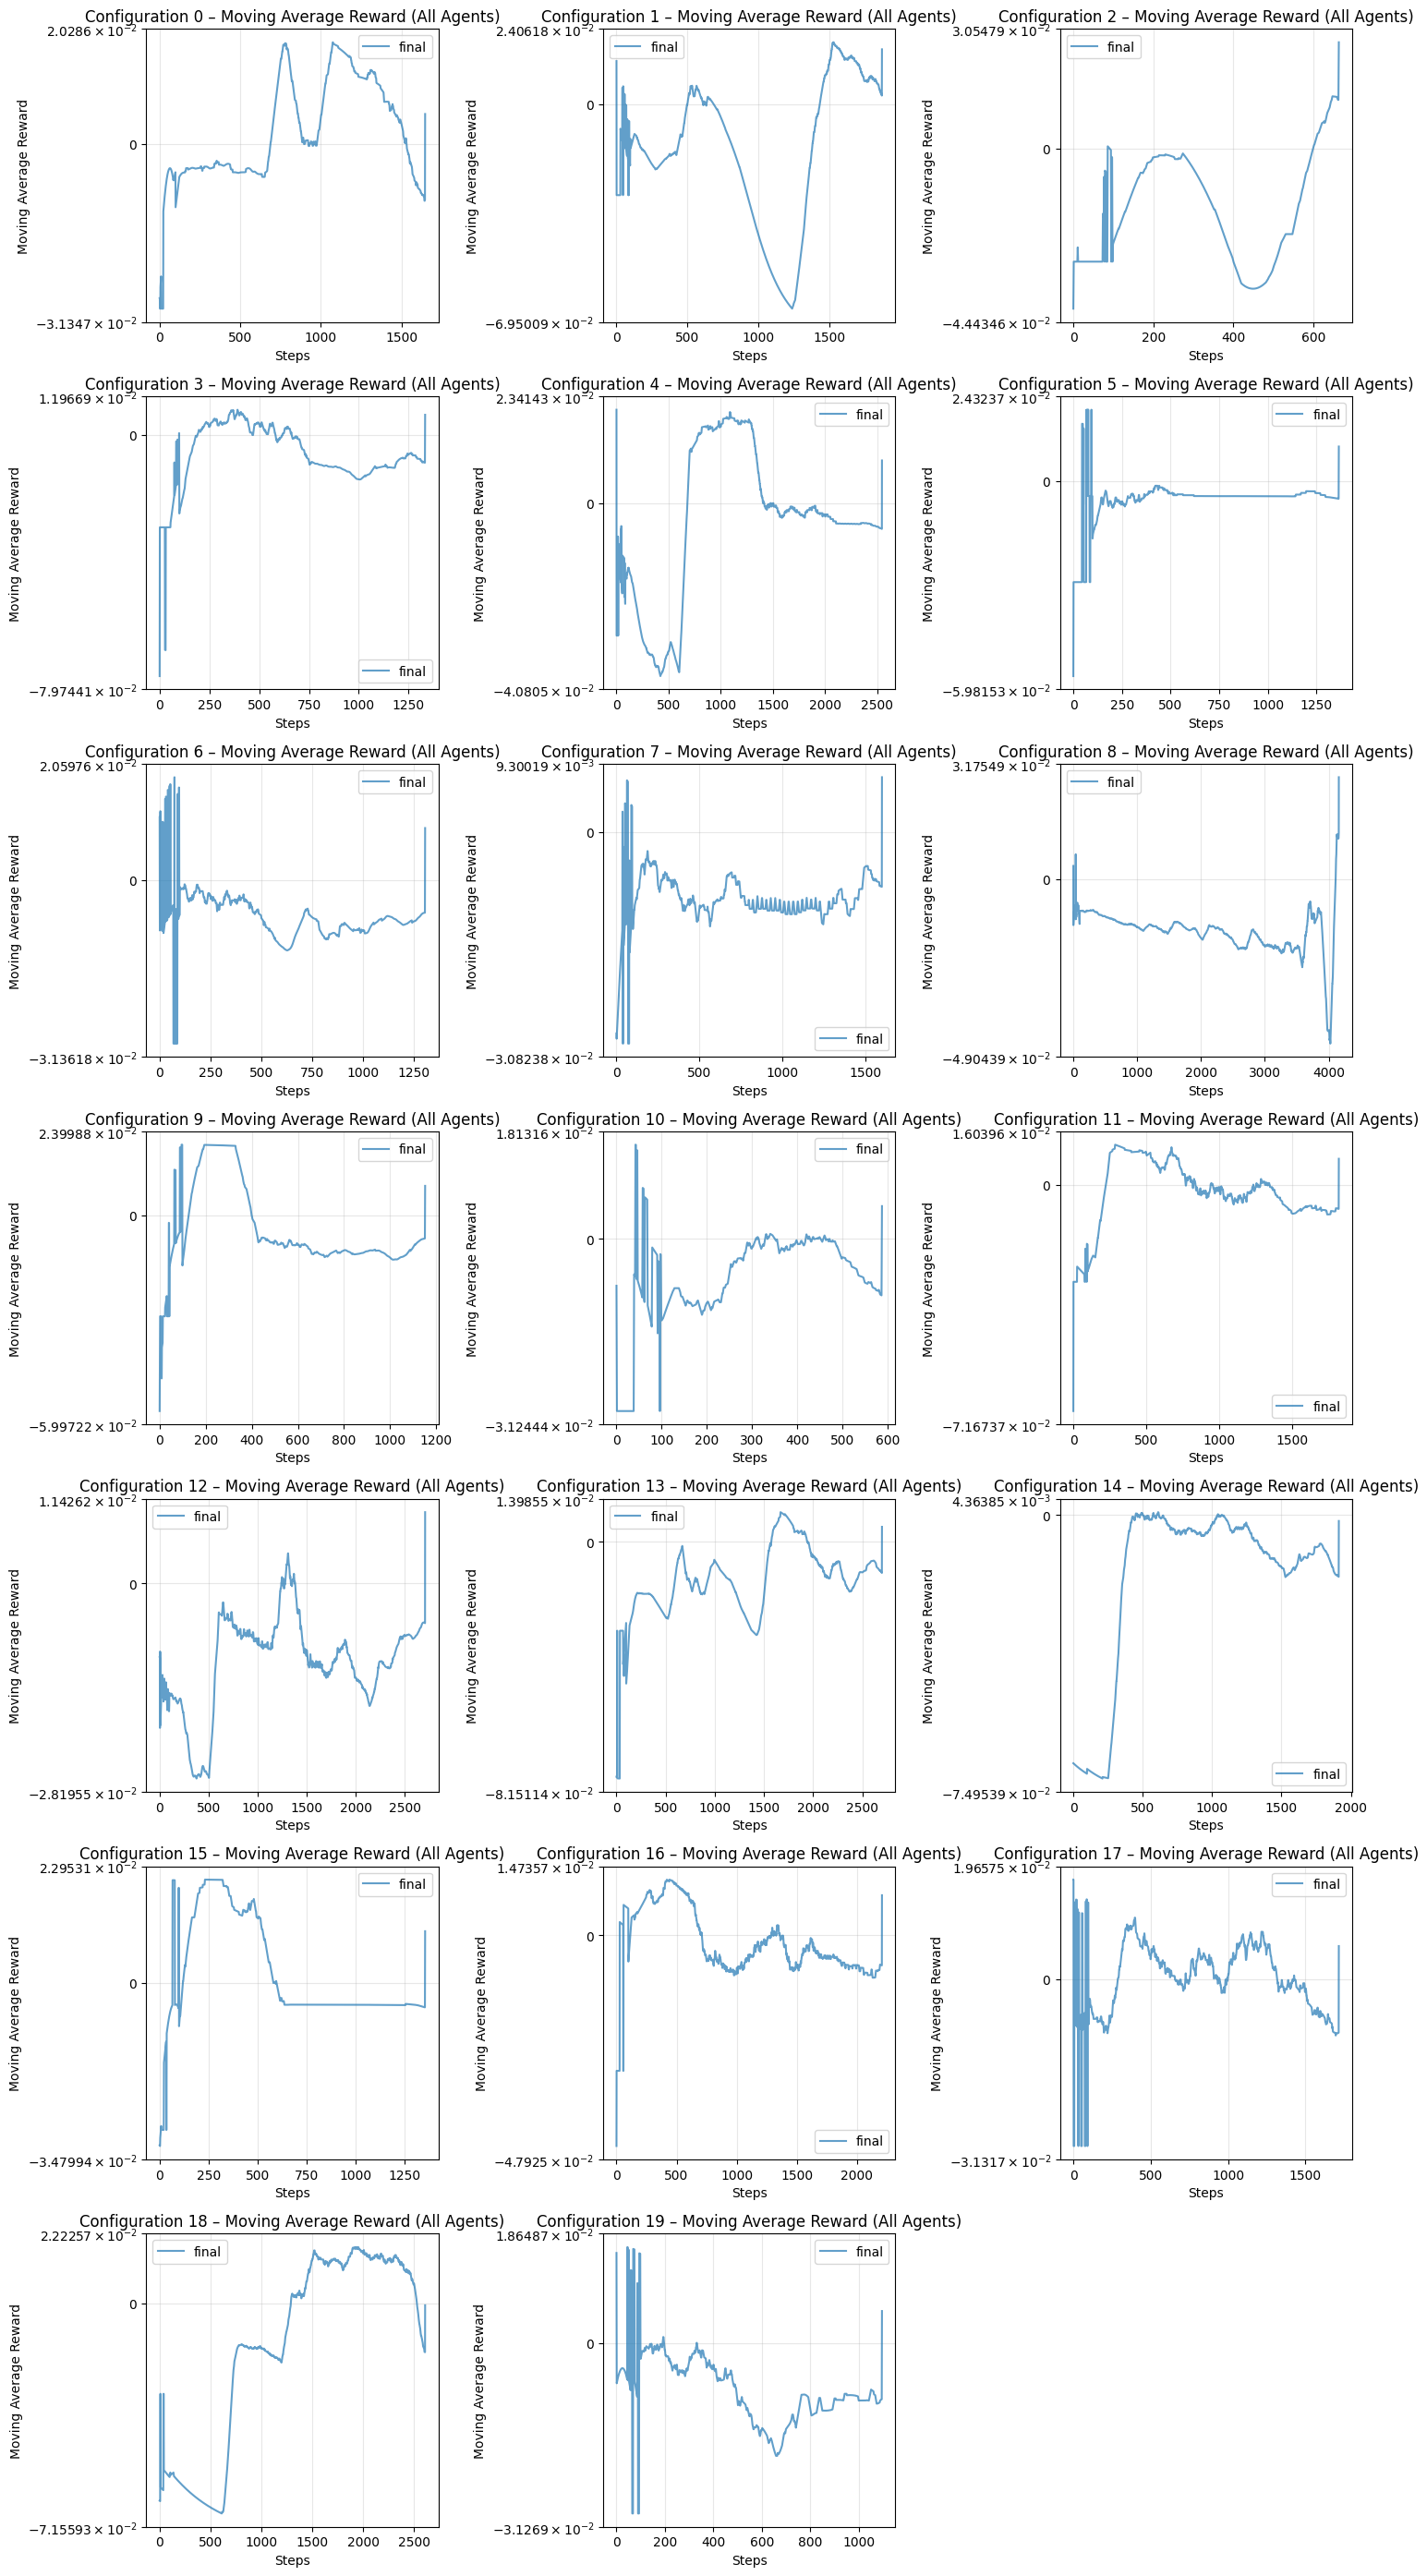

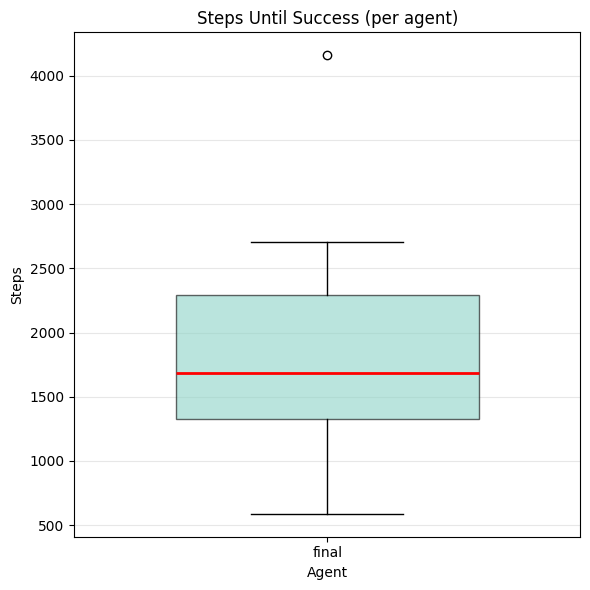

In [14]:
plot_all(dq_final_results_5, agents=["final"])
plot_all(dq_final_results_20, agents=["final"])
plot_all(dq_final_results_30, agents=["final"])

## Valutazione delle Performance

La valutazione viene effettuata su ambienti di dimensioni crescenti per testare la capacità di generalizzazione dell'agente:

| Dimensione | Ambienti | Max Steps | Success Rate |
|------------|----------|-----------|--------------|
| **5×5** | 50 | 5.000 | **86%** |
| **20×20** | 40 | 20.000 | **95%** |
| **30×30** | 20 | 30.000 | **100%** |

### Analisi dei Risultati per Dimensione

- **5×5 (86%)**: ambienti più piccoli del training (10×10). L'agente generalizza bene anche su scale ridotte, dimostrando di aver appreso il comportamento di navigazione verso la luce indipendentemente dalle dimensioni dell'arena;

- **20×20 (95%)**: risultato eccellente su ambienti doppi rispetto al training. L'agente dimostra un'ottima capacità di generalizzazione, riuscendo a navigare efficacemente anche su distanze maggiori. Il trend stabile della reward indica una navigazione consistente;

- **30×30 (100%)**: risultato perfetto su ambienti tripli rispetto al training. Questo risultato si spiega con:
  1. l'agente ha tempo sufficiente per esplorare e raggiungere il goal;
  2. l'agente ha imparato a seguire il gradiente luminoso indipendentemente dalla scala;

### Considerazioni sulla Generazione degli Ambienti di Test

È importante sottolineare che i risultati ottenuti (specialmente il 100% su 30×30) sono influenzati anche dalla **qualità degli ambienti di valutazione**, selezionati con criteri specifici:

- negli ambienti con più sorgenti luminose, le luci sono state posizionate a distanza sufficiente l'una dall'altra. Questo rende il *farming* (oscillare al confine del raggio luminoso) molto più difficile da sfruttare, poiché non esistono zone di sovrapposizione favorevoli.

- le sorgenti luminose sono state collocate evitando posizioni troppo vicine ai bordi dell'arena, garantendo che l'agente abbia sempre spazio di manovra per raggiungerle senza rimanere intrappolato.
- negli ambienti 30×30, i raggi di illuminazione garantiscono una copertura significativa dell'arena, evitando scenari di esplorazione prolungata al buio completo. Questo permette all'agente di intercettare rapidamente un gradiente luminoso durante l'esplorazione.

### Metriche Calcolate

- **Success Rate**: percentuale di episodi in cui l'agente raggiunge la luce;
- **Average Steps**: numero medio di passi per raggiungere il goal (solo episodi di successo);
- **Average Reward**: reward medio ottenuto durante gli episodi;
- **TD Loss**: errore di predizione della rete (indica stabilità dell'apprendimento).

### Analisi della TD Loss e Stabilità

Uno degli indicatori più affidabili della qualità dell'apprendimento in una rete neurale profonda è la **TD Loss** (*Temporal Difference Loss*), che misura l'errore tra la predizione dell'agente (Q-value stimato) e la realtà osservata (Reward + γ × valore del prossimo stato).

#### Interpretazione dei Grafici

Osservando i grafici generati durante la valutazione si osserva che:

1. la diminuzione progressiva della loss media indica che la rete sta effettivamente "imparando a predire". L'agente riduce la discrepanza tra le sue aspettative e i risultati delle sue azioni, stabilizzando la policy.

2. a differenza dell'apprendimento supervisionato, nel Reinforcement Learning i picchi improvvisi di loss non indicano necessariamente un malfunzionamento. In task come il *phototaxis*, essi corrispondono spesso a **eventi rari ad alto valore**:
   - raggiungimento improvviso della luce (reward positiva alta);
   - collisione inaspettata (reward negativa alta);
   - transizioni di stato insolite.

3. una varianza elevata ma stabile indica che l'agente sta esplorando efficacemente, mentre una varianza che aumenta nel tempo può segnalare instabilità nell'apprendimento.

#### Considerazioni sulla Stabilità

La stabilità del DQN dipende fortemente dalla **frequenza di aggiornamento della target network**. Con `step_per_update_target = 1000`, la rete target viene aggiornata ogni 1000 step, fornendo un obiettivo stabile per il calcolo della TD loss. Valori troppo bassi causano oscillazioni, valori troppo alti rallentano l'apprendimento.

## Problemi riscontrati e soluzioni

Il passaggio da uno spazio discreto a uno continuo ha introdotto complessità impreviste. A differenza dell'approccio tabellare, dove i problemi erano principalmente legati alla dimensione della memoria, nel DQN le criticità sono emerse nella **dinamica comportamentale** dell'agente.

### 1. Reward Hacking e  "Farming"

Una delle osservazioni più interessanti è stata la capacità dell'agente di trovare scorciatoie nella funzione di ricompensa. Nelle prime iterazioni, l'agente aveva imparato a posizionarsi esattamente al confine del raggio di luce, oscillando avanti e indietro.
Questa strategia, definita "Farming", permetteva di accumulare indefinitamente la ricompensa positiva legata all'avvicinamento (`prev_dist - curr_dist`), evitando intenzionalmente di entrare nel goal per non far terminare l'episodio.

**Soluzione:** il problema è stato risolto modificando strutturalmente l'incentivo: è stata introdotta una penalità temporale (il tempo diventa un costo) e ridotto l'orizzonte temporale dell'episodio, rendendo il completamento del task l'unica strategia matematicamente vantaggiosa rispetto all'accumulo passivo.

### 2. Incoerenza Sensoriale

Un tentativo di accelerare l'apprendimento fornendo una reward di direzione anche quando l'agente era al buio (cieco) ha prodotto risultati disastrosi (peggioramento del 13%). L'analisi ha rivelato che si stava creando un'incoerenza semantica: si chiedeva alla rete di associare un input nullo (tutti i sensori a 0) a un output direzionale specifico.

**Osservazione:** questo ha dimostrato che la **coerenza tra osservazione e ricompensa** è critica quanto l'architettura della rete. L'agente non può imparare una policy se il feedback che riceve contraddice i suoi input sensoriali. La soluzione definitiva (V7) premia la direzione solo quando esiste un segnale luminoso rilevabile, forzando l'esplorazione casuale in caso di buio totale.

### 3. Generalizzazione e "Fear of the Dark"

L'utilizzo di un dataset sbilanciato verso spawn "in luce" aveva inizialmente creato agenti incapaci di muoversi al buio. A causa di una penalità iniziale troppo severa per il non-movimento, l'agente sviluppava una sorta di "paralisi" (minimo locale), preferendo rimanere immobile per minimizzare le perdite piuttosto che rischiare l'esplorazione.

**Soluzione:** è stato necessario curare manualmente il dataset di training (bilanciamento 57% in luce / 43% al buio) e normalizzare le reward, permettendo all'agente di apprendere due comportamenti distinti: il *gradient tracking* (quando vede la luce) e la *random exploration* (quando è al buio).


### Analisi Qualitativa e Comportamenti Emergenti

Le sessioni di **debug visivo** e l'analisi delle traiettorie hanno permesso di isolare comportamenti specifici emersi durante le diverse fasi del training. Di seguito vengono descritte le dinamiche osservate, distinguendo tra le problematiche risolte e le strategie di navigazione avanzata apprese dall'agente.

#### Risoluzione del "Farming"


Nelle fasi intermedie dello sviluppo, prima della calibrazione del rapporto tra *GoalBonus* e potenziale di *farming*, l'agente DQN aveva sviluppato un **comportamento opportunistico**: oscillava indefinitamente al limite del raggio luminoso compiendo movimenti fluidi per accumulare reward parziali.
L'introduzione di **vincoli temporali stretti** ha invertito questa logica economica. La "pressione" indotta dal timeout ha reso il guadagno marginale dell'oscillazione trascurabile rispetto al rischio di non terminare l'episodio, portando l'agente ad attraversare il confine della luce senza esitazioni e riducendo drasticamente la problematica.

![Final DAgent Behavior](../resources/pho-dqagent-no-farming.gif)

#### Generalizzazione e Scanning Behavior

I test sugli ambienti **30x30** (mai visti durante il training), evidenziano la capacità di generalizzazione del modello. L'agente non naviga affidandosi alla memorizzazione delle coordinate, bensì esegue un **gradient tracking**: campiona l'intensità luminosa e aggiusta la rotazione per massimizzare la derivata del segnale. Questo comportamento si è dimostrato **invariante rispetto alla scala**, risultando efficace sia in ambienti di 5 metri che in arene nettamente più grandi.

Un comportamento emergente particolarmente sofisticato è la strategia di **scanning** adottata durante l'avvicinamento. Invece di procedere in linea retta, l'agente esegue costanti e piccole oscillazioni a destra e sinistra mentre avanza.
Tali movimenti non sono instabilità, ma la rete ha imparato a **scansionare l'ambiente** per confrontare l'intensità luminosa percepita dai sensori laterali. Questo permette di identificare con precisione la direzione di massima intensità, un comportamento che si accentua in prossimità della sorgente dove la **precisione direzionale** diventa critica. Sebbene questa andatura appaia più lenta rispetto a una traiettoria rettilinea, garantisce una maggiore robustezza e accuratezza nel raggiungimento del target.

![Final DAgent Behavior](../resources/pho-dqagent-oa.gif)

#### Wall Avoidance ed Esplorazione

Molto interessante è l'emergere dell'**evitamento ostacoli** (*Wall Avoidance*) e dell'esplorazione, ottenuto fornendo alla rete esclusivamente i valori grezzi dei sensori di prossimità, **senza alcuna regola euristica** pre-programmata.

Quando l'agente si avvicina a un muro, i valori dei sensori di prossimità aumentano. La rete neurale ha appreso empiricamente ad associare questi input ad alta intensità a una futura **penalità di collisione**. Di conseguenza, per prevenire l'impatto, la rete genera autonomamente **azioni di sterzata** che riducono i valori di prossimità, "proteggendo" l'agente.

In quasi assenza di segnale luminoso (sensori luce prossimi allo zero), l'agente impara a non restare immobile grazie alla pressione delle penalità di stazionamento (*StationaryPenalty*) e oscurità (*DarknessPenalty*). La rete produce quindi azioni di **movimento ad ampio raggio**, spesso curve o tratti rettilinei, per massimizzare la probabilità di intercettare un gradiente di luce.


![Final DAgent Behavior](../resources/pho-dqagent-exploration.gif)

La combinazione di **scanning**, **wall avoidance** ed **esplorazione al buio** permette all'agente di adattarsi a scenari complessi, contribuendo in modo determinante agli eccellenti risultati ottenuti negli ambienti di test su larga scala.


# Conclusioni

Un risultato affascinante, comune a entrambi gli approcci ma più evidente nel DQN, è l'emergere dell'**Obstacle Avoidance**.
È fondamentale sottolineare che **non è stata programmata alcuna regola euristica**. L'agente ha appreso la dinamica puramente sperimentando una chiara catena di eventi: la **collisione** viene associata a una penalità immediata; di riflesso, valori elevati dei **sensori di prossimità** vengono interpretati come predittori infallibili di tale dolore imminente. La **rotazione**, portando a un calo dei valori dei sensori, viene quindi selezionata come l'azione necessaria per garantire l'assenza di penalità e la sopravvivenza.

L'agente ha dedotto autonomamente che allontanarsi dai muri preserva la sua "vita", dimostrando una forma primitiva di ragionamento causale appreso.

## Confronto Q-Learning vs Deep Q-Learning

| Aspetto | Q-Learning | Deep Q-Learning |
|---------|------------|-----------------|
| **Success Rate (5x5)** | 90% | 86% |
| **Generalizzazione** | Limitata (solo direzione luce) | Buona (spazio + luce) |
| **Interpretabilità** | Completa (Q-table ispezionabile) | Opaca (black-box) |
| **Scalabilità** | Esponenziale nello spazio stati | Lineare nell'input |

### Analisi della Generalizzazione DQN

I risultati su ambienti di dimensioni diverse mostrano una capacità di generalizzazione notevole:

| Ambiente | Success Rate | Interpretazione |
|----------|--------------|-----------------|
| 5×5 | 86% | Task di base appreso con ottima performance |
| 20×20 | 95% | Eccellente generalizzazione su ambienti più grandi |
| 30×30 | 100% | Perfetta scalabilità su ambienti tripli |

Il **miglioramento progressivo** al crescere delle dimensioni dimostra che l'agente non ha semplicemente memorizzato gli ambienti di training, ma ha appreso una policy generale di navigazione verso il gradiente luminoso. Il successo su 30×30 con 100% di success rate conferma che, dato tempo sufficiente, l'agente è in grado di raggiungere il goal indipendentemente dalla scala dell'ambiente.

La vera differenza tra i due approcci emerge nella **capacità percettiva**:

- **Q-Learning**: l'agente "vede" solo la direzione della luce (8 direzioni cardinali). Non percepisce la scala dell'ambiente né ha una vera gestione delle collisioni. Dal suo punto di vista, un ambiente 5×5 e uno 30×30 sono indistinguibili.

- **DQN**: l'agente elabora i 16 sensori in modo continuo, permettendogli di sviluppare comportamenti emergenti come lo *scanning attivo*, il *wall avoidance* e l'*esplorazione al buio*. Questa ricchezza percettiva si traduce in una capacità di generalizzazione a scale diverse.

## Dalla Specializzazione alla Generalizzazione

Il **Q-Learning** ha vinto in efficienza e trasparenza nel suo dominio specifico. Eccelle in ambienti 5x5 ma la sua percezione limitata lo rende "cieco" alle informazioni spaziali.

Il **Deep Q-Learning** richiede maggiore complessità e un tuning accurato della reward per evitare comportamenti opportunistici, ma restituisce un agente capace di **generalizzare eccezionalmente**. Vede un ostacolo mai visto prima e sa come evitarlo, vede una luce lontana in una stanza enorme e sa come raggiungerla.

In definitiva, se il Q-Learning è la soluzione perfetta per problemi chiusi e definiti, il Deep Learning si conferma l'unica strada percorribile per agenti che devono operare in ambienti aperti, continui e non deterministici.

Il task di phototaxis ha rappresentato un banco di prova significativo per confrontare approcci di reinforcement learning tabellare e deep. La sfida principale non è stata la navigazione in sé, ma il **tuning della funzione di reward** per entrambi gli approcci.

 La rete neurale è un ottimizzatore potente ma "cieco". Se la funzione di ricompensa contiene anche una minima ambiguità (come nel caso del farming), la rete la sfrutterà a discapito del task reale.